# Business Objective:
Need to get sentiment analysis of financial statements and gauge its impact i.e. positive, negative or neutral on the business and government.


In [1]:
#Importing Necessary Libraries for Project
import pandas as pd
import numpy as np
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

#Library for Preprocessing
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk import sent_tokenize
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
lm=WordNetLemmatizer()

#Library for Label Encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

#Library to give weight to the train and test data
from sklearn.model_selection import train_test_split

#Library for Model Evaluation Metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.pipeline import Pipeline

#Library for Model Building
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

#Library for Countvectorizer and Tfidf
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#Library for word2vec
import gensim
from gensim.models import Word2Vec, KeyedVectors

#Library for Downloading word2vec Pretrained model
import gensim.downloader as api
from gensim.utils import simple_preprocess

#Library for Balancing The Data
from imblearn.combine import SMOTEENN

#Library for the dumping the model
import pickle

#Library for Avoiding the warnings
import warnings
warnings.filterwarnings("ignore")

# Understanding The DATA SET

In [2]:
finance_data=pd.read_csv("financial_sentiment_data.csv")
finance_data

Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5842 rows x 2 columns]

# EDA AND FEATURE ENGINEERING

In [3]:
finance_data.shape

(5842, 2)

In [4]:
finance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


#  Duplicated values and their processing

In [5]:
finance_data.duplicated().sum()

6

In [6]:
duplicated_values=finance_data[finance_data.duplicated()]
duplicated_values

Sentence Sentiment
1825  Proha Plc ( Euronext :7327 ) announced today (...   neutral
1859  SSH Communications Security Corporation is hea...   neutral
2672  Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
3272  The company serves customers in various indust...   neutral
3986  The issuer is solely responsible for the conte...   neutral
5342  The report profiles 614 companies including ma...   neutral

In [7]:
Dup=finance_data[finance_data['Sentence']=="SSH Communications Security Corporation is headquartered in Helsinki , Finland ."]
Dup

Sentence Sentiment
815   SSH Communications Security Corporation is hea...   neutral
1859  SSH Communications Security Corporation is hea...   neutral

In [8]:
finance_data=finance_data.drop_duplicates()
finance_data

Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5836 rows x 2 columns]

* The 6 Duplicated rows are removed

In [9]:
finance_data["Sentence"].duplicated().sum()

514

* From this it is seen that 514 no of sentences are reparating , but they are recorded with different emotions
* we have to find the actual emotion form the duplicated datas and find the best dataset

In [10]:
finance_data['polarity']=(round(finance_data['Sentence'].apply(lambda x:TextBlob(x).sentiment.polarity),4))
finance_data

Sentence Sentiment  polarity
0     The GeoSolutions technology will leverage Bene...  positive    0.2091
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative    0.0222
2     For the last quarter of 2010 , Componenta 's n...  positive    0.0000
3     According to the Finnish-Russian Chamber of Co...   neutral    0.0625
4     The Swedish buyout firm has sold its remaining...   neutral   -0.1000
...                                                 ...       ...       ...
5837  RISING costs have forced packaging producer Hu...  negative   -0.3000
5838  Nordic Walking was first used as a summer trai...   neutral    0.2500
5839  According shipping company Viking Line , the E...   neutral    0.1875
5840  In the building and home improvement trade , s...   neutral   -0.4000
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive    0.2500

[5836 rows x 3 columns]

In [11]:
print("the details of Total words polarity:",finance_data.describe())
print("the details of Positive words polarity:",finance_data[finance_data['Sentiment']=="positive"].describe())
print("the details of Neutral words polarity:",finance_data[finance_data['Sentiment']=="neutral"].describe())
print("the details of Negative words polarity:",finance_data[finance_data['Sentiment']=="negative"].describe())

the details of Total words polarity:           polarity
count  5836.000000
mean      0.039184
std       0.182962
min      -1.000000
25%       0.000000
50%       0.000000
75%       0.080000
max       1.000000
the details of Positive words polarity:           polarity
count  1852.000000
mean      0.096589
std       0.208334
min      -0.800000
25%       0.000000
50%       0.000000
75%       0.187500
max       1.000000
the details of Neutral words polarity:           polarity
count  3124.000000
mean      0.023112
std       0.158724
min      -0.800000
25%       0.000000
50%       0.000000
75%       0.050000
max       1.000000
the details of Negative words polarity:          polarity
count  860.000000
mean    -0.026057
std      0.173102
min     -1.000000
25%     -0.077800
50%      0.000000
75%      0.000000
max      0.633300


* from these scroes we cannot attain at a sharp threshold limit for the polarity scores for the different sentiments
* from the description we cannot make the abrupt threshold function since it is mixed up in the dataset

In [12]:
finance_data["Sentence"].duplicated().sum()
#514 are missing and in these data the sentiments are being different for the same statement

514

In [13]:
duplicated_values=finance_data[finance_data["Sentence"].duplicated(keep=False)]
duplicated_values

Sentence Sentiment  polarity
7     SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...  negative    0.3500
13             Viking Line has canceled some services .   neutral    0.0000
41    Dolce & Gabbana has asked the European Union t...  negative    0.0000
57    Diluted earnings per share ( EPS ) fell to EUR...   neutral    0.0000
66    Finnish GeoSentric 's net sales decreased to E...  negative   -0.2000
...                                                 ...       ...       ...
5827  ( ADPnews ) - Oct 21 , 2009 - Finland-based IT...  negative    0.0833
5831  Finnish developer and manufacturer of mobile p...  negative    0.0000
5832  Operating profit fell to EUR 38.1 mn from EUR ...  negative    0.0000
5837  RISING costs have forced packaging producer Hu...  negative   -0.3000
5840  In the building and home improvement trade , s...   neutral   -0.4000

[1028 rows x 3 columns]

* only the negative and neutral data is the issue here

In [15]:
duplicated_values.describe()

polarity
count  1028.000000
mean     -0.041832
std       0.157444
min      -0.700000
25%      -0.103700
50%       0.000000
75%       0.000000
max       0.600000

In [16]:
print("the shape of the original dataset:",finance_data.shape)
print("the shape of the duplicated dataset alone:",duplicated_values.shape)
print("the no of rows removing duplicates:",(5836-1028))

the shape of the original dataset: (5836, 3)
the shape of the duplicated dataset alone: (1028, 3)
the no of rows removing duplicates: 4808


In [17]:
finance_data=finance_data.drop_duplicates(subset="Sentence",keep=False)

In [18]:
finance_data.shape

(4808, 3)

In [19]:
duplicated_values.sort_values(by="polarity")

Sentence Sentiment  polarity
5801  At this growth rate , paying off the national ...  negative      -0.7
2522  At this growth rate , paying off the national ...   neutral      -0.7
2868    It is a disappointment to see the plan folded .   neutral      -0.6
4511    It is a disappointment to see the plan folded .  negative      -0.6
5762  Finnish Suominen Flexible Packaging is cutting...  negative      -0.6
...                                                 ...       ...       ...
2161  Tornio Works employs 2,300 of whom more than 1...  negative       0.5
329   He said he has been losing five families a mon...  negative       0.5
2863  He said he has been losing five families a mon...   neutral       0.5
2440  Biohit said that it will reduce the number of ...  negative       0.6
1080  Biohit said that it will reduce the number of ...   neutral       0.6

[1028 rows x 3 columns]

In [20]:
negative_polarity_scored=duplicated_values[duplicated_values["polarity"]<0]
print(negative_polarity_scored.shape)
negative_polarity_scored.sort_values(by="polarity").head(25)

(416, 3)


Sentence Sentiment  polarity
2522  At this growth rate , paying off the national ...   neutral      -0.7
5801  At this growth rate , paying off the national ...  negative      -0.7
5762  Finnish Suominen Flexible Packaging is cutting...  negative      -0.6
4774  Finnish Suominen Flexible Packaging is cutting...   neutral      -0.6
2868    It is a disappointment to see the plan folded .   neutral      -0.6
4511    It is a disappointment to see the plan folded .  negative      -0.6
1357  Ruukki Group calculates that it has lost EUR 4...   neutral      -0.5
5305  `` Capital expenditure on energy efficiency ha...  negative      -0.5
3972  Ruukki Group calculates that it has lost EUR 4...  negative      -0.5
2915  LONDON MarketWatch -- Share prices ended lower...  negative      -0.5
5107  LONDON MarketWatch -- Share prices ended lower...   neutral      -0.5
4279  `` Capital expenditure on energy efficiency ha...   neutral      -0.5
3183  Comparable operating profit decreased to EUR 1...  negative      -0.4
3025  Comparable operating profit decreased to EUR 1...   neutral      -0.4
2975  Pretax profit decreased by 37 % to EUR 193.1 m...   neutral      -0.4
2927  In July-September 2009 , Konecranes ' sales de...  negative      -0.4
2944  Operating profit decreased to EUR 16mn from EU...   neutral      -0.4
2552  In the building and home improvement trade , s...   neutral      -0.4
3392     Sales of mid-strength beer decreased by 40 % .  negative      -0.4
2209  Earnings per share EPS in 2005 decreased to EU...   neutral      -0.4
2158  Earnings per share ( EPS ) in 2005 decreased t...   neutral      -0.4
2078  Operating profit decreased to EUR 11.2 mn from...   neutral      -0.4
2069  Device volume in the area decreased by 21 % to...  negative      -0.4
2035  In July-September 2009 , Konecranes ' sales de...   neutral      -0.4
1559  Operating result for the 12-month period decre...  negative      -0.4

In [21]:
neutral_polarity_scored=duplicated_values[duplicated_values["polarity"]==0]
print(neutral_polarity_scored.shape)
neutral_polarity_scored.sort_values(by="Sentence").head(25)

(408, 3)


Sentence Sentiment  polarity
855   ( ADPnews ) - Feb 3 , 2010 - Finland-based ste...  negative       0.0
806   ( ADPnews ) - Feb 3 , 2010 - Finland-based ste...   neutral       0.0
2644  18 March 2010 A leakage in the gypsum pond was...  negative       0.0
4384  18 March 2010 A leakage in the gypsum pond was...   neutral       0.0
498   2009 3 February 2010 - Finland-based steel mak...  negative       0.0
3283  2009 3 February 2010 - Finland-based steel mak...   neutral       0.0
5664  25 March 2011 - Finnish electronics contract m...  negative       0.0
2968  25 March 2011 - Finnish electronics contract m...   neutral       0.0
1260  55 workers in +àm+Ñl will be affected by the c...  negative       0.0
5438  55 workers in +àm+Ñl will be affected by the c...   neutral       0.0
4217  A total of 140 jobs will be reduced at the Raa...  negative       0.0
3687  A total of 140 jobs will be reduced at the Raa...   neutral       0.0
3845  ADP News - May 29 , 2009 - Bank of America Bof...  negative       0.0
3063  ADP News - May 29 , 2009 - Bank of America Bof...   neutral       0.0
5515  ADPnews - Sep 28 , 2009 - Finnish silicon wafe...   neutral       0.0
2974  ADPnews - Sep 28 , 2009 - Finnish silicon wafe...  negative       0.0
3857  Acando AB ( ACANB SS ) fell 8.9 percent to 13....   neutral       0.0
398   Acando AB ( ACANB SS ) fell 8.9 percent to 13....  negative       0.0
2791  According to Arokarhu , some of the purchases ...   neutral       0.0
5378  According to Arokarhu , some of the purchases ...  negative       0.0
4554  Agricultural newspaper Maaseudun Tulevaisuus h...   neutral       0.0
1762  Agricultural newspaper Maaseudun Tulevaisuus h...  negative       0.0
1921  Also construction expenses have gone up in Rus...  negative       0.0
2495  Also construction expenses have gone up in Rus...   neutral       0.0
257   Altogether Finnair has canceled over 500 fligh...  negative       0.0

In [22]:
positive_polarity_scored=duplicated_values[duplicated_values["polarity"]>0]
print(positive_polarity_scored.shape)
positive_polarity_scored.sort_values(by="polarity").head(25)

(204, 3)


Sentence Sentiment  polarity
3530  Finnish Scanfil , a systems supplier and contr...  negative    0.0019
1763  Finnish Scanfil , a systems supplier and contr...   neutral    0.0019
169   Making matters more difficult , the company sa...   neutral    0.0048
387   Making matters more difficult , the company sa...  negative    0.0048
2706  Hobby Hall 's sales decrease 26 pct due to imp...   neutral    0.0057
5569  Hobby Hall 's sales decrease 26 pct due to imp...  negative    0.0057
601   Finnish electronics manufacturing services EMS...   neutral    0.0167
1016  Finnish electronics manufacturing services EMS...  negative    0.0167
2098  20 October 2010 - Finnish environmental manage...  negative    0.0167
3720  20 October 2010 - Finnish environmental manage...   neutral    0.0167
1987  ADPnews - Jul 17 , 2009 - Finland-based steel ...  negative    0.0208
885   Group EBIT for the first half was EUR13 .6 m U...   neutral    0.0208
2235  11 August 2010 - Finnish measuring equipment m...  negative    0.0208
3780  Group EBIT for the first half was EUR13 .6 m U...  negative    0.0208
3514  11 August 2010 - Finnish measuring equipment m...   neutral    0.0208
3797  ADPnews - Jul 17 , 2009 - Finland-based steel ...   neutral    0.0208
2841  SRV lowered its net sales estimate for the who...  negative    0.0250
4075  SRV lowered its net sales estimate for the who...   neutral    0.0250
2375  The decision means temporary lay-offs of fixed...  negative    0.0250
102   The decision means temporary lay-offs of fixed...   neutral    0.0250
822   ADPnews - Aug 3 , 2009 - Finnish media group I...   neutral    0.0278
5558  Finnish communication electronics components s...   neutral    0.0278
1696  Finnish communication electronics components s...  negative    0.0278
5148  ADPnews - Aug 3 , 2009 - Finnish media group I...  negative    0.0278
4007  Finnish electronics contract manufacturer Scan...   neutral    0.0315

* from using this Polarity Scores we can make a conclusion that the polarity scores less than zero can be classified as the negative sentiment 
* for the polarity score equal to zero can be concluded as neutral statements
* but the statements with polarity score greater that zero cannot be easily concluded and there are 52 unique statements in such category
* Hence for this but mannualy reading and understanding the statements we can make an assumption that that the statements having positive polarity scores are also negative in the sense of nature and hence the statements with polarity scores other than zero are to considerd as Negative sentiments

In [23]:
def n_Sentiment(polarity):
    
    if polarity==0:
        x='neutral'
    else:
        x='negative'
    return x

In [24]:
duplicated_values['N_Sentiment']=duplicated_values['polarity'].apply(lambda x: n_Sentiment(x))

In [25]:
duplicated_values.sort_values(by="Sentence")

Sentence Sentiment  polarity  \
3685  ( ADP News ) - Feb 11 , 2009 - Finnish wood pr...  negative   -0.2000   
4578  ( ADP News ) - Feb 11 , 2009 - Finnish wood pr...   neutral   -0.2000   
1488  ( ADP News ) - Feb 12 , 2009 - Finnish constru...  negative   -0.2000   
3765  ( ADP News ) - Feb 12 , 2009 - Finnish constru...   neutral   -0.2000   
1051  ( ADP News ) - Feb 4 , 2009 - Finnish broadban...  negative   -0.2000   
...                                                 ...       ...       ...   
5612  down to EUR5 .9 m H1 '09 3 August 2009 - Finni...   neutral   -0.0181   
904   in Finland Finnish pharmaceutical company Orio...   neutral    0.0000   
3368  in Finland Finnish pharmaceutical company Orio...  negative    0.0000   
3075  stores 16 March 2010 - Finnish stationery and ...  negative    0.0000   
4663  stores 16 March 2010 - Finnish stationery and ...   neutral    0.0000   

     N_Sentiment  
3685    negative  
4578    negative  
1488    negative  
3765    negative  
1051    negative  
...          ...  
5612    negative  
904      neutral  
3368     neutral  
3075     neutral  
4663     neutral  

[1028 rows x 4 columns]

In [26]:
df = duplicated_values.drop_duplicates(subset='Sentence',keep="first")
df.shape

(514, 4)

In [27]:
df=df.drop(['Sentiment'], axis=1)

In [28]:
df=df.iloc[:,[0,2,1]]

In [29]:
df.rename(columns = {"N_Sentiment": "Sentiment"},inplace = True)
df

Sentence Sentiment  polarity
7     SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...  negative    0.3500
13             Viking Line has canceled some services .   neutral    0.0000
41    Dolce & Gabbana has asked the European Union t...   neutral    0.0000
57    Diluted earnings per share ( EPS ) fell to EUR...   neutral    0.0000
66    Finnish GeoSentric 's net sales decreased to E...  negative   -0.2000
...                                                 ...       ...       ...
5448  Finnish media group Talentum has issued a prof...   neutral    0.0000
5472  The largest restructuring is planned for Italy...   neutral    0.0000
5550  The negotiation has resulted in the reduction ...  negative   -0.0833
5570  Last year , 8.3 million passengers flew the ai...  negative   -0.0778
5634  Net sales decreased to EUR 220.5 mn from EUR 4...  negative   -0.2000

[514 rows x 3 columns]

In [30]:
finance_data.shape

(4808, 3)

* Now to combine the finance and df data

In [31]:
finance_data.tail()

Sentence Sentiment  polarity
5835  HSBC Says Unit to Book $585 Million Charge on ...  negative    0.0000
5836  Daily Mail parent company in talks with potent...  positive    0.0000
5838  Nordic Walking was first used as a summer trai...   neutral    0.2500
5839  According shipping company Viking Line , the E...   neutral    0.1875
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive    0.2500

In [32]:
datas=[finance_data,df]
finance_sentiments=pd.concat(datas)

In [33]:
finance_sentiments

Sentence Sentiment  polarity
0     The GeoSolutions technology will leverage Bene...  positive    0.2091
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative    0.0222
2     For the last quarter of 2010 , Componenta 's n...  positive    0.0000
3     According to the Finnish-Russian Chamber of Co...   neutral    0.0625
4     The Swedish buyout firm has sold its remaining...   neutral   -0.1000
...                                                 ...       ...       ...
5448  Finnish media group Talentum has issued a prof...   neutral    0.0000
5472  The largest restructuring is planned for Italy...   neutral    0.0000
5550  The negotiation has resulted in the reduction ...  negative   -0.0833
5570  Last year , 8.3 million passengers flew the ai...  negative   -0.0778
5634  Net sales decreased to EUR 220.5 mn from EUR 4...  negative   -0.2000

[5322 rows x 3 columns]

# To check the distribution of the dataset

<AxesSubplot: xlabel='Sentiment', ylabel='count'>

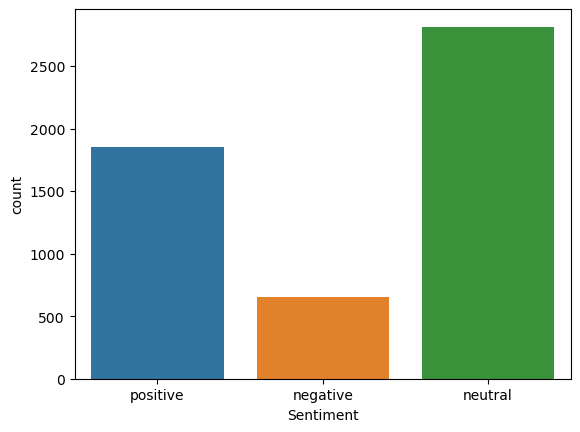

In [34]:
sns.countplot(x=finance_sentiments["Sentiment"])

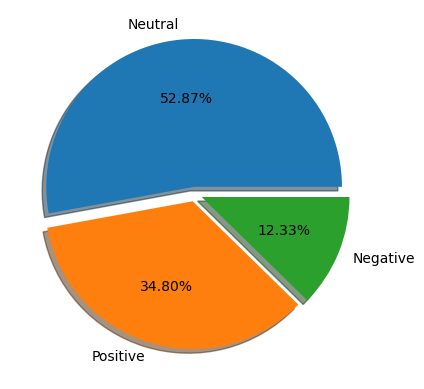

In [35]:
plt.pie(finance_sentiments.Sentiment.value_counts()/len(finance_sentiments),      
        labels =['Neutral','Positive','Negative'],
        autopct='%1.2f%%',shadow=True,explode=(0.05, 0.05,0.05)) 

plt.show()

From this plot ,we can see that the dataset is unbalanced , which means that the dataset does not provide almost equal number of cases for all the different types of sentiment that must be predicted
* It is obvious that the Sentiment “Neutral” is the dominant one. Having an unbalanced dataset may lead us to
* classifiers/models that can not identify and classify cases that belong to positive or negative Sentiments and they may
* misclassify them.

In [36]:
#plotting of the Wordcloud 
def plot_cloud(wordcloud):
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud)
    plt.axis('off')

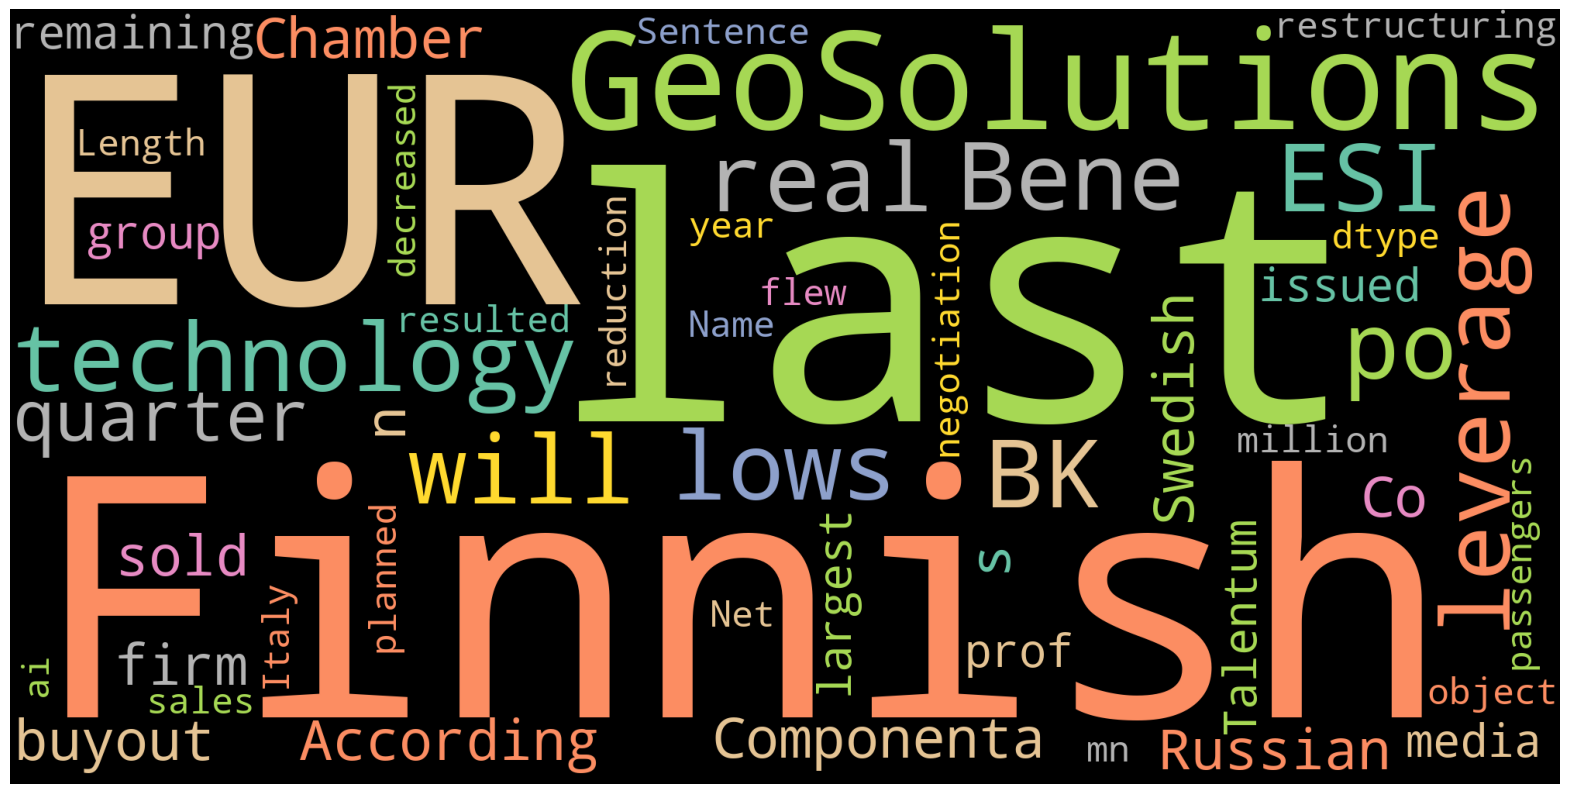

In [37]:
# Generate word cloud for the entire dataset
wordcloud=WordCloud(width=2000,height=1000,background_color='black',max_words=200,
                    colormap='Set2').generate(str(finance_sentiments['Sentence']))
plot_cloud(wordcloud)

In [38]:
tokenized_text = ' '.join(finance_sentiments['Sentence']).split()

In [39]:
print(tokenized_text)

['The', 'GeoSolutions', 'technology', 'will', 'leverage', 'Benefon', "'s", 'GPS', 'solutions', 'by', 'providing', 'Location', 'Based', 'Search', 'Technology', ',', 'a', 'Communities', 'Platform', ',', 'location', 'relevant', 'multimedia', 'content', 'and', 'a', 'new', 'and', 'powerful', 'commercial', 'model', '.', '$ESI', 'on', 'lows,', 'down', '$1.50', 'to', '$2.50', 'BK', 'a', 'real', 'possibility', 'For', 'the', 'last', 'quarter', 'of', '2010', ',', 'Componenta', "'s", 'net', 'sales', 'doubled', 'to', 'EUR131m', 'from', 'EUR76m', 'for', 'the', 'same', 'period', 'a', 'year', 'earlier', ',', 'while', 'it', 'moved', 'to', 'a', 'zero', 'pre-tax', 'profit', 'from', 'a', 'pre-tax', 'loss', 'of', 'EUR7m', '.', 'According', 'to', 'the', 'Finnish-Russian', 'Chamber', 'of', 'Commerce', ',', 'all', 'the', 'major', 'construction', 'companies', 'of', 'Finland', 'are', 'operating', 'in', 'Russia', '.', 'The', 'Swedish', 'buyout', 'firm', 'has', 'sold', 'its', 'remaining', '22.4', 'percent', 'stak

In [40]:
word_counts = Counter(tokenized_text)

* printing the most common words repeating

In [41]:
print(word_counts.most_common(20))

[('the', 4243), ('.', 4154), (',', 4018), ('of', 2929), ('in', 2520), ('to', 2435), ('and', 2332), ('a', 1566), ('The', 1218), ('for', 1154), ('EUR', 890), ('is', 866), ("'s", 855), ('from', 757), ('will', 746), ('on', 721), ('company', 686), ('its', 560), ('by', 537), ('as', 528)]


In [42]:
print(word_counts)

Counter({'the': 4243, '.': 4154, ',': 4018, 'of': 2929, 'in': 2520, 'to': 2435, 'and': 2332, 'a': 1566, 'The': 1218, 'for': 1154, 'EUR': 890, 'is': 866, "'s": 855, 'from': 757, 'will': 746, 'on': 721, 'company': 686, 'its': 560, 'by': 537, 'as': 528, 'be': 519, 'with': 512, 'mn': 509, 'has': 501, ')': 450, '(': 449, 'said': 447, 'at': 444, 'Finnish': 438, 'sales': 432, 'million': 414, '%': 408, 'profit': 392, 'that': 361, 'net': 351, 'it': 349, 'was': 339, '-': 337, ':': 309, 'Finland': 287, 'mln': 281, 'an': 275, '2009': 273, 'are': 268, 'year': 259, '2008': 258, 'period': 252, 'm': 247, 'share': 245, 'new': 236, 'quarter': 235, 'up': 235, '2007': 227, '2010': 214, '``': 212, '$': 206, 'market': 197, 'which': 196, 'have': 195, 'shares': 194, 'business': 194, 'Oyj': 193, 'In': 193, 'also': 183, 'first': 180, "''": 174, 'this': 170, 'operating': 168, 'Group': 164, '2006': 160, 'services': 159, 'been': 151, 'loss': 148, 'euro': 140, 'today': 138, 'about': 136, 'compared': 134, 'operation

* By viewing the wordcloud and the dataset  we can see the there are many links found in the text
* many currency names found in the sentences which does not influence the text
* many years and share values  are reported comparing its previuos years reports which cannot be used in sentiment analysis
* many measurments are found alonf with their units which do not contribute to the sentiments
* there are many organisation names and country names which cannot influence sentiments
* hence there are many symbols and some words with different cases we can carry over preprocessing of the data and then carry on these analysis part

## Text preprocessing

In [43]:
def text_cleaning(Text):
    
    #removal of the link
    Text = re.sub('https?://\S+|www\.\S+', '', Text)
    #removal of punctuatoins
    punc=str.maketrans(string.punctuation,' '*len(string.punctuation))
    Text=Text.translate(punc)
    #removal of numbers
    Text = re.sub(r'\d+', '', Text)
    #removal of the special characters
    Text=re.sub(r'[^\w\s]', '', Text) 
    #removing extra white spaces
    text = re.sub('\s+', ' ', Text).strip()
    #lower case transformation
    Text=Text.lower()
    #remove the non-english alphabets
    Text=re.sub(r'[^\u0000-\u007F]+', '', Text)
    
    return Text

In [44]:
finance_sentiments['Sentence']=finance_sentiments['Sentence'].apply(text_cleaning)

In [45]:
finance_sentiments

Sentence Sentiment  polarity
0     the geosolutions technology will leverage bene...  positive    0.2091
1      esi on lows  down    to    bk a real possibility  negative    0.0222
2     for the last quarter of    componenta  s net s...  positive    0.0000
3     according to the finnish russian chamber of co...   neutral    0.0625
4     the swedish buyout firm has sold its remaining...   neutral   -0.1000
...                                                 ...       ...       ...
5448  finnish media group talentum has issued a prof...   neutral    0.0000
5472  the largest restructuring is planned for italy...   neutral    0.0000
5550  the negotiation has resulted in the reduction ...  negative   -0.0833
5570  last year     million passengers flew the airl...  negative   -0.0778
5634  net sales decreased to eur   mn from eur   mn ...  negative   -0.2000

[5322 rows x 3 columns]

In [46]:
processed_finance=finance_sentiments
positive_processed_finance=finance_sentiments[finance_sentiments['Sentiment']=='positive']
negative_processed_finance=finance_sentiments[finance_sentiments['Sentiment']=='negative']
neutral_processed_finance=finance_sentiments[finance_sentiments['Sentiment']=='neutral']

In [47]:
positive_processed_finance

Sentence Sentiment  polarity
0     the geosolutions technology will leverage bene...  positive    0.2091
2     for the last quarter of    componenta  s net s...  positive    0.0000
5        spy wouldn t be surprised to see a green close  positive   -0.0500
8     kone  s net sales rose by some    year on year...  positive    0.2833
10    circulation revenue has increased by    in fin...  positive    0.0000
...                                                 ...       ...       ...
5819  last month we added to our  gild position and ...  positive    0.0206
5824     in the newly formed company yit stavo the l...  positive    0.0455
5825  friends life lifts profits   and hikes divi ah...  positive    0.0000
5836  daily mail parent company in talks with potent...  positive    0.0000
5841  helsinki afx   kci konecranes said it has won ...  positive    0.2500

[1852 rows x 3 columns]

1.The Wordcloud for Positive sentiments
2.The Wordcloud for negative sentiments
3.The Wordcloud for neutral sentiments


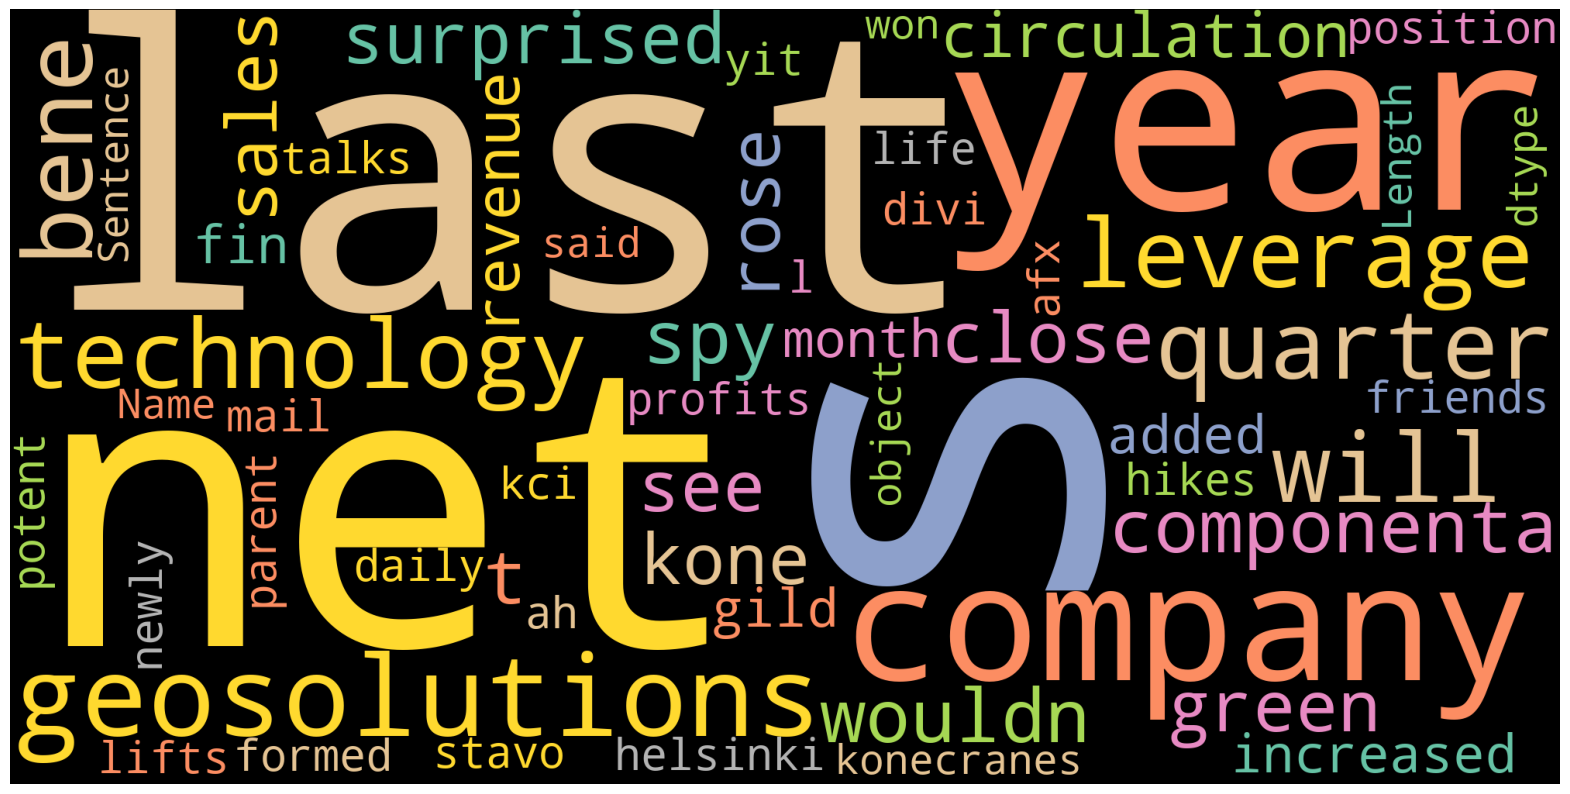

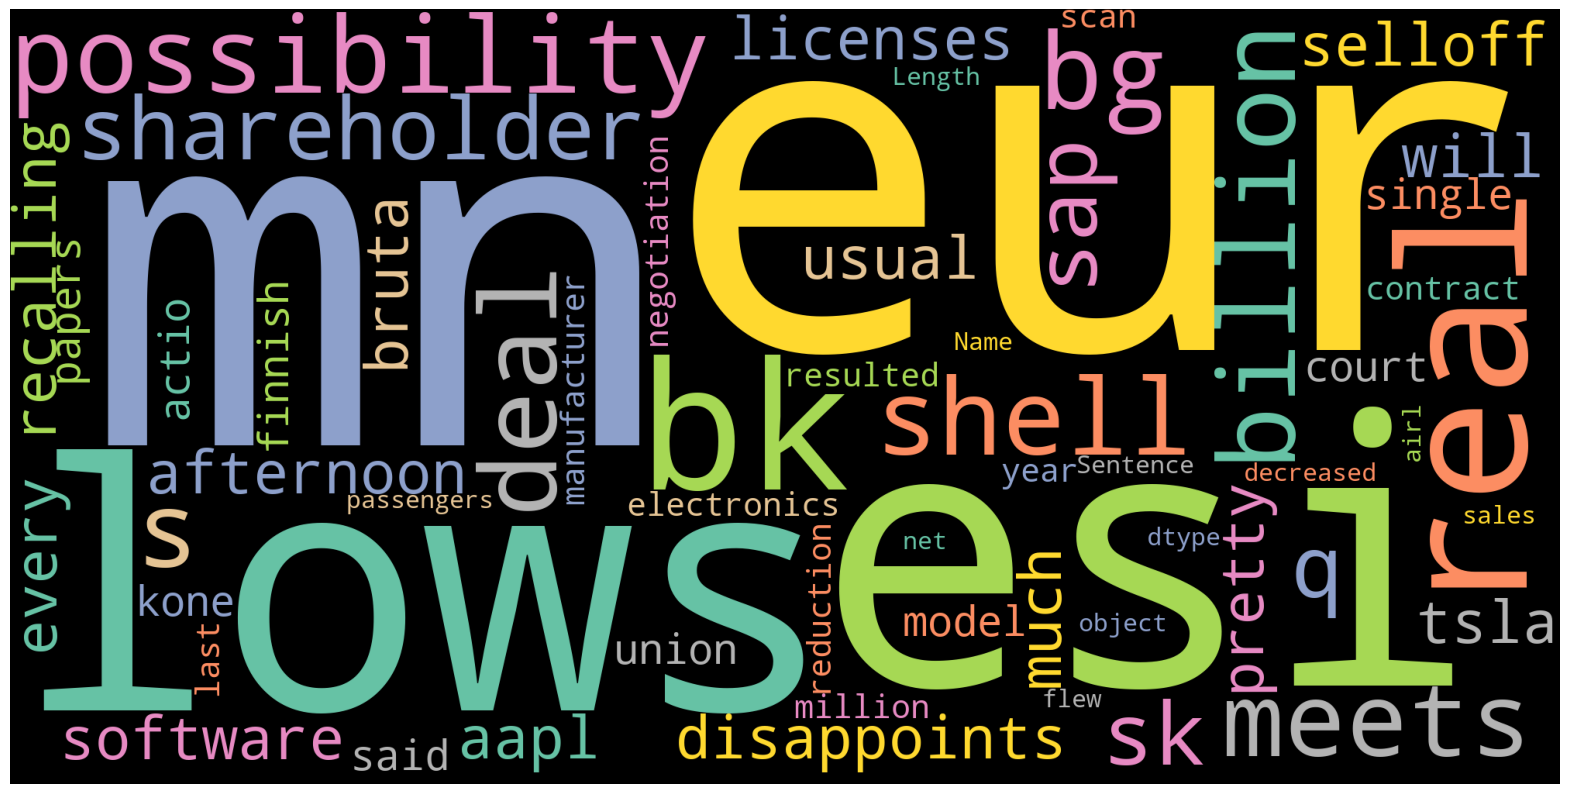

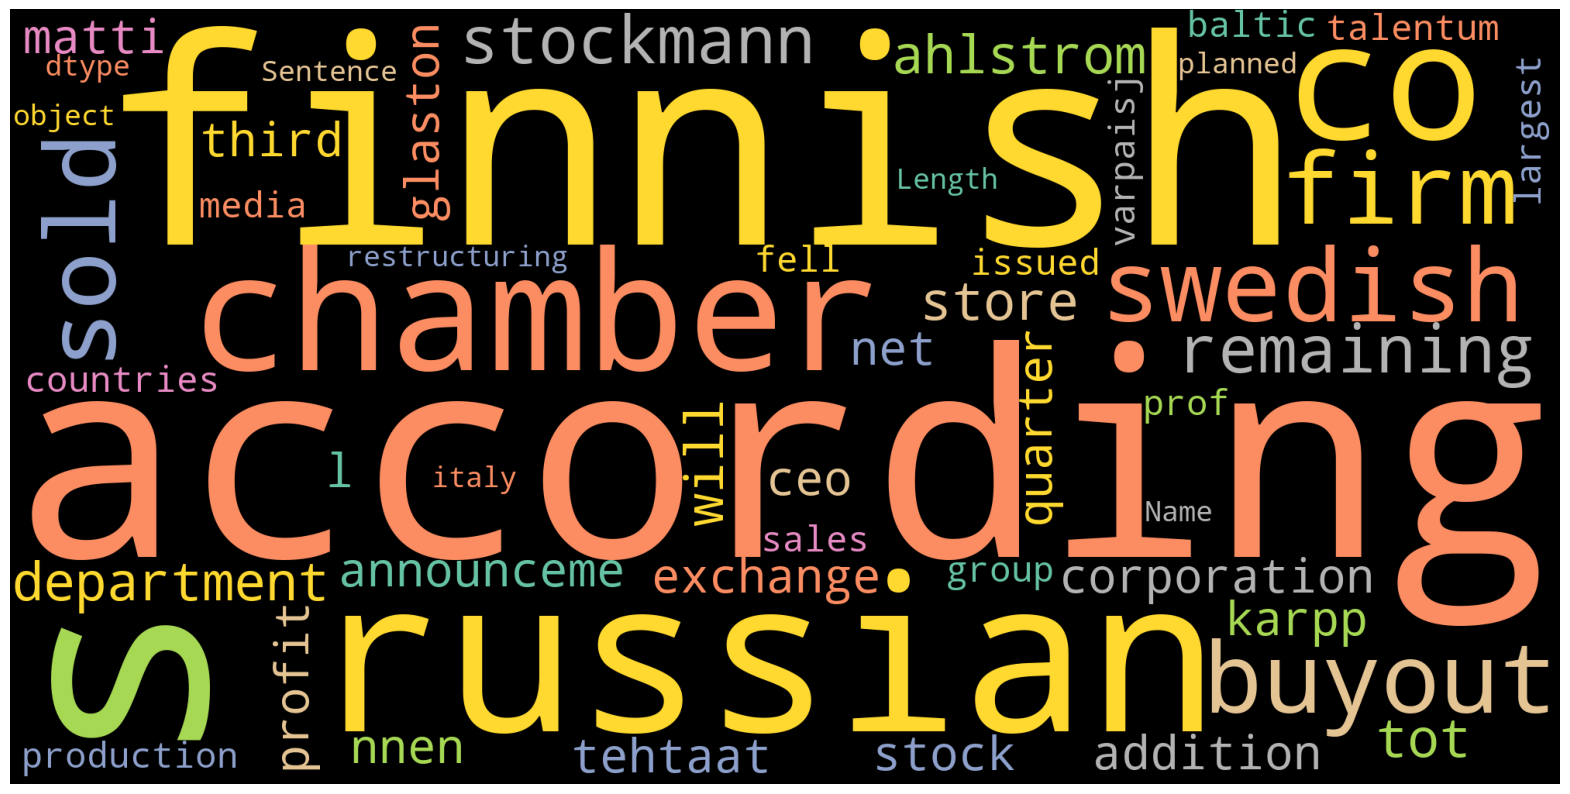

In [48]:
# Generate word cloud for the positive dataset
wordcloud_1=WordCloud(width=2000,height=1000,background_color='black',max_words=200,colormap='Set2'
                    ,collocations=False).generate(str(positive_processed_finance['Sentence']))
plot_cloud(wordcloud_1)
print("1.The Wordcloud for Positive sentiments")

# Generate word cloud for the negative dataset
wordcloud_2=WordCloud(width=2000,height=1000,background_color='black',max_words=200,colormap='Set2'
                    ,collocations=False).generate(str(negative_processed_finance['Sentence']))
plot_cloud(wordcloud_2)

print("2.The Wordcloud for negative sentiments")

# Generate word cloud for the neutral dataset
wordcloud_3=WordCloud(width=2000,height=1000,background_color='black',max_words=200,colormap='Set2'
                    ,collocations=False).generate(str(neutral_processed_finance['Sentence']))
plot_cloud(wordcloud_3)
print("3.The Wordcloud for neutral sentiments")

In [49]:
tokenized_text_all=' '.join(processed_finance['Sentence']).split()
tokenized_text_positive = ' '.join(positive_processed_finance['Sentence']).split()
tokenized_text_negative = ' '.join(negative_processed_finance['Sentence']).split()
tokenized_text_neutral = ' '.join(neutral_processed_finance['Sentence']).split()

In [50]:
word_counts_all=Counter(tokenized_text_all)
word_counts_positive = Counter(tokenized_text_positive)
word_counts_negative = Counter(tokenized_text_negative)
word_counts_neutral = Counter(tokenized_text_neutral)

In [51]:
print("positive",word_counts_positive.most_common(20))
print("Negative",word_counts_negative.most_common(20))
print("Neutral",word_counts_neutral.most_common(20))

positive [('the', 1450), ('to', 985), ('in', 937), ('of', 806), ('and', 649), ('eur', 584), ('a', 575), ('for', 453), ('s', 383), ('from', 381), ('on', 261), ('mn', 259), ('its', 233), ('with', 220), ('year', 218), ('sales', 216), ('profit', 203), ('company', 203), ('by', 197), ('net', 197)]
Negative [('the', 481), ('in', 307), ('to', 279), ('of', 266), ('eur', 250), ('a', 165), ('from', 156), ('and', 153), ('mn', 150), ('for', 135), ('down', 114), ('profit', 98), ('on', 94), ('sales', 85), ('s', 84), ('net', 81), ('year', 73), ('as', 69), ('by', 66), ('at', 64)]
Neutral [('the', 3536), ('of', 1877), ('and', 1558), ('in', 1490), ('to', 1216), ('a', 951), ('is', 660), ('s', 607), ('for', 592), ('will', 558), ('company', 478), ('on', 431), ('eur', 422), ('be', 382), ('as', 364), ('with', 294), ('its', 289), ('at', 289), ('has', 285), ('by', 284)]


In [52]:
print(word_counts_all)

Counter({'the': 5467, 'of': 2949, 'in': 2734, 'to': 2480, 'and': 2360, 'a': 1691, 'eur': 1256, 'for': 1180, 's': 1074, 'is': 879, 'on': 786, 'from': 769, 'will': 762, 'company': 731, 'as': 589, 'mn': 588, 'its': 571, 'with': 550, 'by': 547, 'be': 520, 'has': 506, 'at': 487, 'sales': 473, 'it': 460, 'said': 452, 'finnish': 448, 'million': 420, 'profit': 419, 'net': 401, 'year': 388, 'm': 386, 'that': 371, 'was': 340, 'finland': 302, 'group': 300, 'an': 288, 'mln': 285, 'operating': 282, 'up': 278, 'new': 277, 'are': 274, 'share': 260, 'quarter': 258, 'period': 254, 'business': 243, 'this': 233, 'market': 220, 'shares': 213, 'oyj': 202, 'also': 199, 'have': 197, 'which': 197, 'services': 192, 'first': 189, 'euro': 169, 'today': 168, 'loss': 156, 'been': 151, 'about': 143, 'helsinki': 143, 'down': 139, 'compared': 137, 'operations': 136, 'percent': 133, 'per': 131, 'contract': 131, 'total': 130, 'price': 129, 'after': 126, 'not': 125, 'financial': 124, 'nokia': 120, 'bank': 118, 'based': 

In [53]:
print(word_counts_positive)

Counter({'the': 1450, 'to': 985, 'in': 937, 'of': 806, 'and': 649, 'eur': 584, 'a': 575, 'for': 453, 's': 383, 'from': 381, 'on': 261, 'mn': 259, 'its': 233, 'with': 220, 'year': 218, 'sales': 216, 'profit': 203, 'company': 203, 'by': 197, 'net': 197, 'said': 194, 'up': 188, 'has': 187, 'it': 181, 'finnish': 181, 'm': 174, 'is': 170, 'million': 164, 'will': 161, 'as': 156, 'period': 140, 'at': 134, 'mln': 125, 'that': 123, 'quarter': 120, 'operating': 120, 'an': 110, 'group': 102, 'this': 101, 'be': 100, 'new': 96, 'was': 96, 'rose': 92, 'increased': 89, 'share': 84, 'long': 84, 'oyj': 83, 'today': 81, 'are': 80, 'first': 76, 'loss': 75, 'percent': 74, 'increase': 72, 'compared': 70, 'euro': 68, 'market': 68, 'finland': 67, 'business': 67, 'we': 65, 'corresponding': 64, 'also': 63, 'buy': 62, 'have': 61, 'our': 61, 'services': 58, 'growth': 55, 'aapl': 55, 'which': 55, 'contract': 55, 'after': 51, 'more': 49, 'been': 49, 'operations': 49, 'last': 48, 'per': 48, 'agreement': 47, 'i': 45

In [54]:
print(word_counts_negative)

Counter({'the': 481, 'in': 307, 'to': 279, 'of': 266, 'eur': 250, 'a': 165, 'from': 156, 'and': 153, 'mn': 150, 'for': 135, 'down': 114, 'profit': 98, 'on': 94, 'sales': 85, 's': 84, 'net': 81, 'year': 73, 'as': 69, 'by': 66, 'at': 64, 'decreased': 61, 'first': 60, 'finnish': 57, 'operating': 55, 'quarter': 54, 'period': 54, 'it': 53, 'million': 53, 'm': 52, 'was': 51, 'company': 50, 'is': 49, 'its': 49, 'mln': 48, 'said': 44, 'will': 43, 'be': 38, 'that': 38, 'share': 38, 'lower': 38, 'short': 36, 'with': 36, 'tsla': 34, 'has': 34, 'price': 33, 'half': 33, 'oyj': 33, 'this': 32, 'loss': 32, 'compared': 30, 'today': 28, 'aapl': 27, 'corresponding': 27, 'euro': 27, 'pct': 26, 'than': 26, 'market': 24, 'i': 23, 'after': 22, 'helsinki': 22, 'x': 21, 'spy': 21, 'shares': 21, 'are': 20, 'up': 20, 'fall': 19, 'have': 19, 'off': 19, 'before': 19, 'group': 19, 'model': 18, 'back': 18, 'same': 18, 'hel': 18, 'due': 17, 'earlier': 17, 'finland': 17, 'fb': 16, 'not': 16, 'been': 16, 'usd': 16, 'o

In [55]:
print(word_counts_neutral)

Counter({'the': 3536, 'of': 1877, 'and': 1558, 'in': 1490, 'to': 1216, 'a': 951, 'is': 660, 's': 607, 'for': 592, 'will': 558, 'company': 478, 'on': 431, 'eur': 422, 'be': 382, 'as': 364, 'with': 294, 'its': 289, 'at': 289, 'has': 285, 'by': 284, 'from': 232, 'it': 226, 'finland': 218, 'said': 214, 'finnish': 210, 'that': 210, 'million': 203, 'was': 193, 'mn': 179, 'group': 179, 'are': 174, 'an': 172, 'sales': 172, 'business': 168, 'new': 167, 'shares': 162, 'm': 160, 'share': 138, 'services': 133, 'also': 130, 'which': 130, 'market': 128, 'net': 123, 'profit': 118, 'have': 117, 'mln': 112, 'operating': 107, 'total': 104, 'this': 100, 'year': 97, 'about': 96, 'helsinki': 93, 'not': 90, 'been': 86, 'oyj': 86, 'quarter': 84, 'financial': 84, 'based': 83, 'were': 83, 'other': 82, 'value': 81, 'capital': 80, 'plant': 78, 'nokia': 78, 'production': 77, 'corporation': 76, 'operations': 76, 'products': 75, 'bank': 75, 'euro': 74, 'board': 73, 'mobile': 73, 'investment': 72, 'according': 71, '

* we can find the repeating words in  the all the different sentiments

In [56]:
# here we get output type is list

# finding unique items for postive sentiment
tokenized_text_positive
unique_items_positive = []
for item in tokenized_text_positive:
    if item not in unique_items_positive:
        unique_items_positive.append(item)
#print(unique_items_positive)
# finding unique items for negative sentiment
tokenized_text_negative
unique_items_negative = []
for item in tokenized_text_negative:
    if item not in unique_items_negative:
        unique_items_negative.append(item)
#print(unique_items_negative)
# finding unique items for neutral sentiment
tokenized_text_neutral
unique_items_neutral = []
for item in tokenized_text_neutral:
    if item not in unique_items_neutral:
        unique_items_neutral.append(item)
#print(unique_items_neutral)
# the words which are common in the neutral, negative, sentiment
common_words = []
for word in unique_items_positive:
    if word in unique_items_negative and word in unique_items_neutral:
        common_words.append(word)

In [57]:
print(len(common_words))
print(type(common_words))

1278
<class 'list'>


In [58]:
print(common_words)

['the', 'technology', 'will', 's', 'gps', 'solutions', 'by', 'based', 'search', 'a', 'and', 'new', 'commercial', 'model', 'for', 'last', 'quarter', 'of', 'componenta', 'net', 'sales', 'to', 'eurm', 'from', 'same', 'period', 'year', 'earlier', 'while', 'it', 'moved', 'pre', 'tax', 'profit', 'loss', 't', 'be', 'see', 'green', 'close', 'kone', 'rose', 'some', 'on', 'in', 'first', 'nine', 'months', 'revenue', 'has', 'increased', 'finland', 'sweden', 'made', 'eur', 'million', 'operating', 'profits', 'fb', 'day', 'double', 'with', 'over', 'aviva', 'life', 'top', 'ahead', 'billion', 'merger', 'ceo', 'up', 'get', 'board', 'dividend', 'play', 'cost', 'stockmann', 'swedish', 'sector', 'company', 'ab', 'into', 'an', 'september', 'or', 'subsidiary', 'make', 'public', 'all', 'issued', 'shares', 'we', 'are', 'group', 'royal', 'dutch', 'shell', 'buy', 'bg', 'nearly', 'included', 'restructuring', 'costs', 'm', 'they', 'were', 'diluted', 'eps', 'stood', 'at', 'versus', 'per', 'share', 'according', 'fin

**To convert collections.counter, We need to convert it to dictonaries and then data frame for removal top most common words**

In [59]:
word_counts_all = Counter(tokenized_text_all)

In [60]:
type(word_counts_all)

collections.Counter

In [61]:
print(word_counts_all.most_common(10))

[('the', 5467), ('of', 2949), ('in', 2734), ('to', 2480), ('and', 2360), ('a', 1691), ('eur', 1256), ('for', 1180), ('s', 1074), ('is', 879)]


In [62]:
counts_dict_all = dict(word_counts_all)

In [63]:
# converting dictonary to data frames for all words
df_1 = pd.DataFrame.from_dict(counts_dict_all, orient = 'index', columns = ['count of words'])
df_1.reset_index(inplace= True)

In [64]:
df_1.rename(columns={'index':'words'}, inplace = True)

In [65]:
df_1

words  count of words
0               the            5467
1      geosolutions               2
2        technology              95
3              will             762
4          leverage               3
...             ...             ...
10076        halved               1
10077       repairs               1
10078    courthouse               1
10079   saltonstall               1
10080          flew               1

[10081 rows x 2 columns]

In [66]:
# arranging them in descending order
df_1 = df_1.sort_values('count of words', ascending = False)

In [67]:
df_1.shape

(10081, 2)

In [68]:
#  filtering the words
filtered_df = df_1[df_1["words"].isin(common_words)]

In [69]:
print(filtered_df)

           words  count of words
0            the            5467
36            of            2949
67            in            2734
29            to            2480
20           and            2360
...          ...             ...
2843           v               3
3286     margins               3
2446        fill               3
3222  impressive               3
3097          dt               3

[1278 rows x 2 columns]


In [70]:
df_2 = filtered_df.head(200)

In [71]:
df_2.shape

(200, 2)

In [72]:
df_2 = df_2.drop('count of words', axis=1)

In [73]:
df_2.head

<bound method NDFrame.head of               words
0               the
36               of
67               in
29               to
20              and
...             ...
197             ltd
1027  manufacturing
1235          lower
581           april
657            cash

[200 rows x 1 columns]>

In [74]:
words_200 = df_2['words'].tolist()

In [75]:
print(words_200)

['the', 'of', 'in', 'to', 'and', 'a', 'eur', 'for', 's', 'is', 'on', 'from', 'will', 'company', 'as', 'mn', 'its', 'with', 'by', 'be', 'has', 'at', 'sales', 'it', 'said', 'finnish', 'million', 'profit', 'net', 'year', 'm', 'that', 'was', 'finland', 'group', 'an', 'mln', 'operating', 'up', 'new', 'are', 'share', 'quarter', 'period', 'business', 'this', 'market', 'shares', 'oyj', 'also', 'have', 'which', 'services', 'first', 'euro', 'today', 'loss', 'been', 'about', 'helsinki', 'down', 'compared', 'operations', 'percent', 'contract', 'per', 'total', 'price', 'after', 'not', 'financial', 'nokia', 'bank', 'based', 'stock', 'were', 'we', 'than', 'corresponding', 'products', 'some', 'corporation', 'long', 'mobile', 'more', 'capital', 'or', 'over', 'according', 'other', 'production', 'plant', 'well', 'value', 'increased', 'all', 'rose', 'one', 'hel', 'companies', 'our', 'plc', 'deal', 'solutions', 'technology', 'service', 'now', 'investment', 'order', 'unit', 'board', 'last', 'their', 'second

* by viewing these files we can see that there are country names,brand names, curerency names, share names and certain other domain specific words and also the words referring the time period  are present in the dataset and also they do not contribute to mine the emotion as they can be present in all the sentiments 
* also there are many stopwords to be removed from the dataset as they do not contribute to the emotion but before removing the dataset we have to check the ngrams since there may be possibility that these stopwords may be contributing to the emotions when they are continued are followed by the other words 

In [76]:
Stopwords = (set(nltk.corpus.stopwords.words("english")))

In [77]:
Stopwords 
# these are the stop words and these words are also to be considered for check in the ngram analyiss

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [78]:
def Gram_Analysis(Corpus, Gram, N):

    Vectorizer = CountVectorizer(stop_words=None, ngram_range=(Gram,Gram))
    ngrams = Vectorizer.fit_transform(Corpus)
    Count = ngrams.sum(axis=0)
    words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]
    words = sorted(words, key = lambda x:x[1], reverse = True)

    return words[:N]

#  Bigram Analysis

In [79]:
words_p = Gram_Analysis(positive_processed_finance["Sentence"], 2, 30)
Bigram_processed_positive_data = pd.DataFrame(words_p, columns = ["Words", "Counts"])
Bigram_processed_positive_data

Words  Counts
0                 in the     267
1                 eur mn     250
2               from eur     174
3                 to eur     167
4                for the     151
5                 of the     114
6            the company     114
7              net sales     101
8       operating profit     100
9                  mn in      88
10           eur million      87
11            quarter of      75
12                of eur      69
13     the corresponding      64
14  corresponding period      63
15               rose to      63
16             the first      61
17               up from      59
18             period in      53
19            net profit      52
20           compared to      52
21                on the      51
22                to the      50
23               mn from      49
24               its net      46
25           profit rose      44
26              euro mln      42
27              mln euro      41
28              the same      40
29                 to be      39

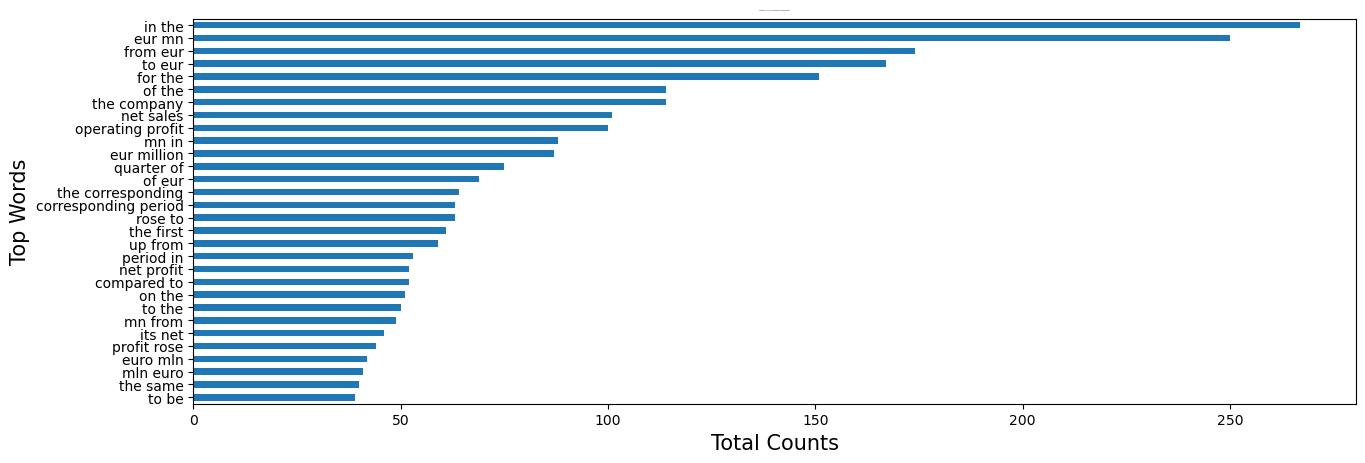

In [80]:
Bigram_processed_positive_data.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", figsize = (15, 5))
plt.title("2-gram of Reviews with positive Sentiments", loc = "center", fontsize = 1)
plt.xlabel("Total Counts", fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15)
plt.show()

In [81]:
words_p = Gram_Analysis(negative_processed_finance["Sentence"], 2, 30)
Bigram_processed_negative_data = pd.DataFrame(words_p, columns = ["Words", "Counts"])
Bigram_processed_negative_data

Words  Counts
0                 eur mn     146
1                 in the     111
2               from eur      81
3                 to eur      71
4                for the      67
5                  mn in      64
6              the first      54
7              down from      49
8              net sales      39
9       operating profit      36
10                of eur      32
11           the company      30
12               mn down      30
13          decreased to      29
14           eur million      29
15                of the      28
16            quarter of      27
17     the corresponding      27
18            first half      26
19  corresponding period      26
20               half of      26
21            net profit      26
22         first quarter      24
23           compared to      24
24               and the      23
25               its net      21
26             period in      21
27              euro mln      20
28           share price      19
29          decreased by      19

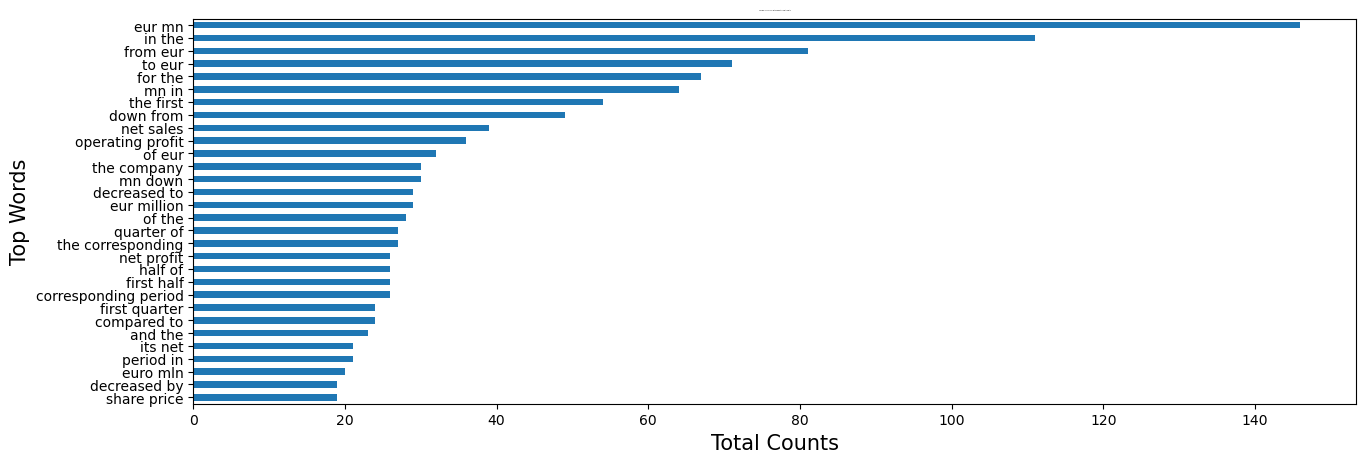

In [82]:
Bigram_processed_negative_data.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", figsize = (15, 5))
plt.title("2-gram of Reviews with Negative Sentiments", loc = "center", fontsize = 1)
plt.xlabel("Total Counts", fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15)
plt.show()

In [83]:
words_p = Gram_Analysis(neutral_processed_finance["Sentence"], 2, 30)
Bigram_processed_neutral_data = pd.DataFrame(words_p, columns = ["Words", "Counts"])
Bigram_processed_neutral_data

Words  Counts
0             of the     508
1             in the     347
2        the company     298
3            will be     208
4             to the     155
5             eur mn     154
6            for the     124
7             on the     115
8            and the     111
9             of eur     110
10         net sales      92
11             to be      89
12       eur million      88
13        in finland      86
14            at the      82
15            by the      80
16      according to      70
17           as well      66
18           part of      64
19           well as      64
20          with the      63
21          value of      61
22            to eur      57
23          from the      54
24           the new      53
25          sales of      52
26             mn in      51
27          has been      51
28        quarter of      51
29  operating profit      50

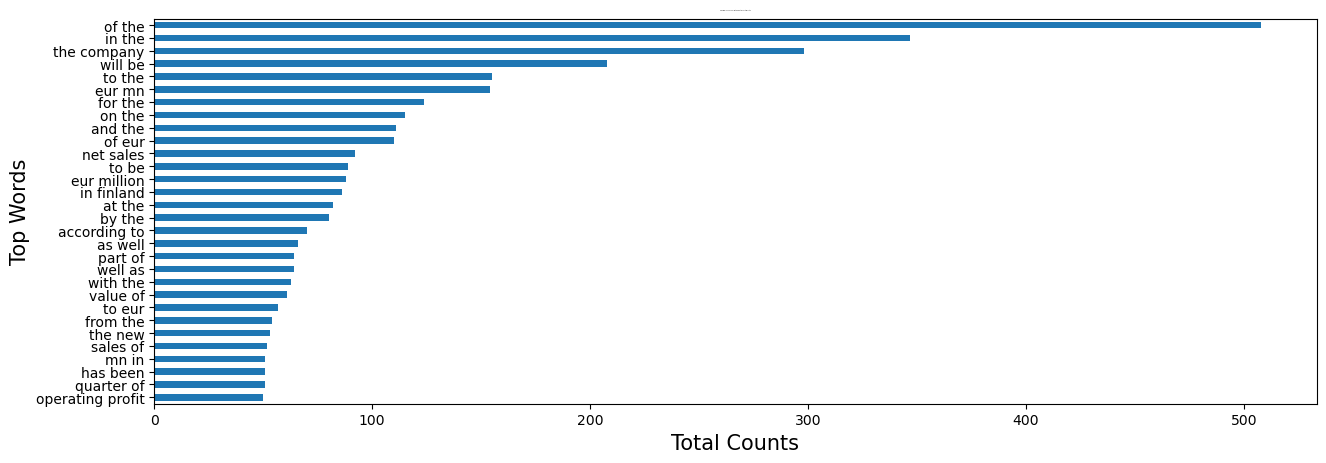

In [84]:
Bigram_processed_neutral_data.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", figsize = (15, 5))
plt.title("2-gram of Reviews with neutral Sentiments", loc = "center", fontsize = 1)
plt.xlabel("Total Counts", fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15)
plt.show()

In [85]:
bigram_df = pd.DataFrame({'positive_words': Bigram_processed_positive_data['Words'], 'Negative_bigrams': Bigram_processed_negative_data['Words'], 'neutral_bigrams': Bigram_processed_neutral_data['Words']})
bigram_df

positive_words      Negative_bigrams   neutral_bigrams
0                 in the                eur mn            of the
1                 eur mn                in the            in the
2               from eur              from eur       the company
3                 to eur                to eur           will be
4                for the               for the            to the
5                 of the                 mn in            eur mn
6            the company             the first           for the
7              net sales             down from            on the
8       operating profit             net sales           and the
9                  mn in      operating profit            of eur
10           eur million                of eur         net sales
11            quarter of           the company             to be
12                of eur               mn down       eur million
13     the corresponding          decreased to        in finland
14  corresponding period           eur million            at the
15               rose to                of the            by the
16             the first            quarter of      according to
17               up from     the corresponding           as well
18             period in            first half           part of
19            net profit  corresponding period           well as
20           compared to               half of          with the
21                on the            net profit          value of
22                to the         first quarter            to eur
23               mn from           compared to          from the
24               its net               and the           the new
25           profit rose               its net          sales of
26              euro mln             period in             mn in
27              mln euro              euro mln          has been
28              the same           share price        quarter of
29                 to be          decreased by  operating profit

* From this bigram analysis we can find that some words like 
      1. even though profit is a common terms like Operating Profit,net profit is a domain specific term which is to be removed since it does not contribute to the sentiment
      2.the most repeating bigram words are found to be currency or share names and words denoting the periodical specifications

# Trigram analysis

In [86]:
words_p = Gram_Analysis(positive_processed_finance["Sentence"], 3, 30)
Trigram_processed_positive_data = pd.DataFrame(words_p, columns = ["Words", "Counts"])
Trigram_processed_positive_data

Words  Counts
0                from eur mn      89
1                  eur mn in      88
2                  to eur mn      80
3   the corresponding period      63
4                  mn in the      58
5    corresponding period in      52
6                eur mn from      48
7                mn from eur      48
8                rose to eur      47
9       in the corresponding      40
10              mln euro mln      40
11               up from eur      38
12            profit rose to      38
13                 eur mn up      34
14                mn up from      33
15              in the first      32
16            to eur million      29
17           the same period      28
18                 by to eur      28
19              year on year      27
20               loss of eur      25
21        the second quarter      25
22          from eur million      25
23                 of eur mn      25
24            nine months of      24
25         the first quarter      24
26            the first nine      23
27         first nine months      23
28         second quarter of      23
29         the third quarter      22

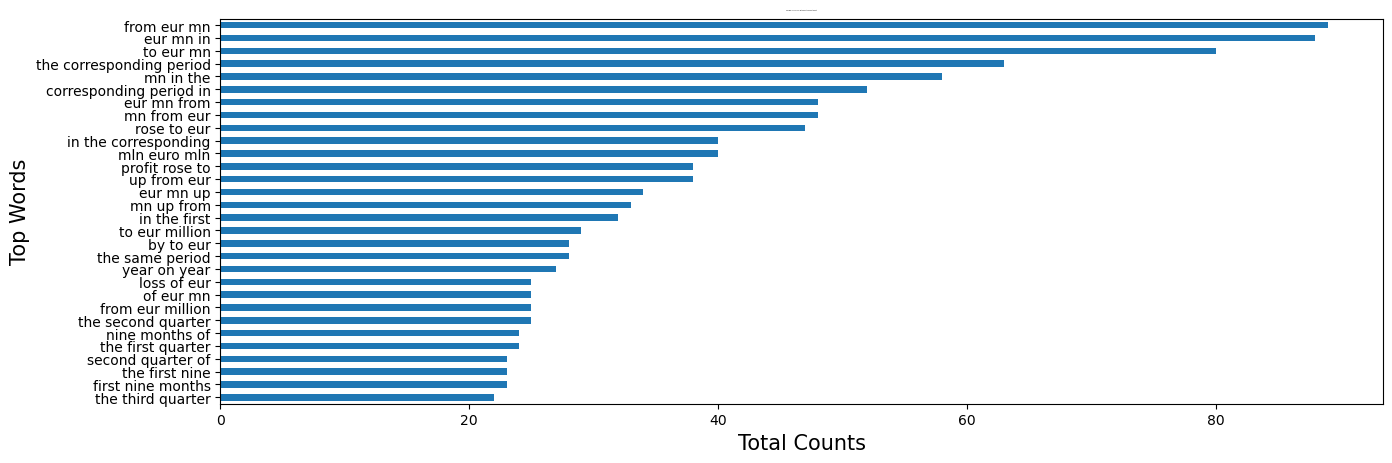

In [87]:
Trigram_processed_positive_data.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", figsize = (15, 5))
plt.title("3-gram of Reviews with positive Sentiments", loc = "center", fontsize = 1)
plt.xlabel("Total Counts", fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15)
plt.show()

In [88]:
words_p = Gram_Analysis(negative_processed_finance["Sentence"], 3, 30)
Trigram_processed_negative_data = pd.DataFrame(words_p, columns = ["Words", "Counts"])
Trigram_processed_negative_data

Words  Counts
0                  eur mn in      63
1                from eur mn      53
2                  mn in the      41
3                  to eur mn      40
4               in the first      35
5              down from eur      34
6                eur mn down      30
7               mn down from      30
8   the corresponding period      26
9             the first half      25
10             first half of      24
11          decreased to eur      23
12         the first quarter      21
13      in the corresponding      20
14   corresponding period in      20
15               eur mn from      19
16               mn from eur      19
17                 of eur mn      17
18              mln euro mln      17
19             for the first      17
20          first quarter of      15
21              euro mln for      14
22           the same period      14
23           totalled eur mn      13
24             profit of eur      13
25          the omx helsinki      13
26               mln for the      13
27            its net profit      12
28            to eur million      12
29       profit decreased to      12

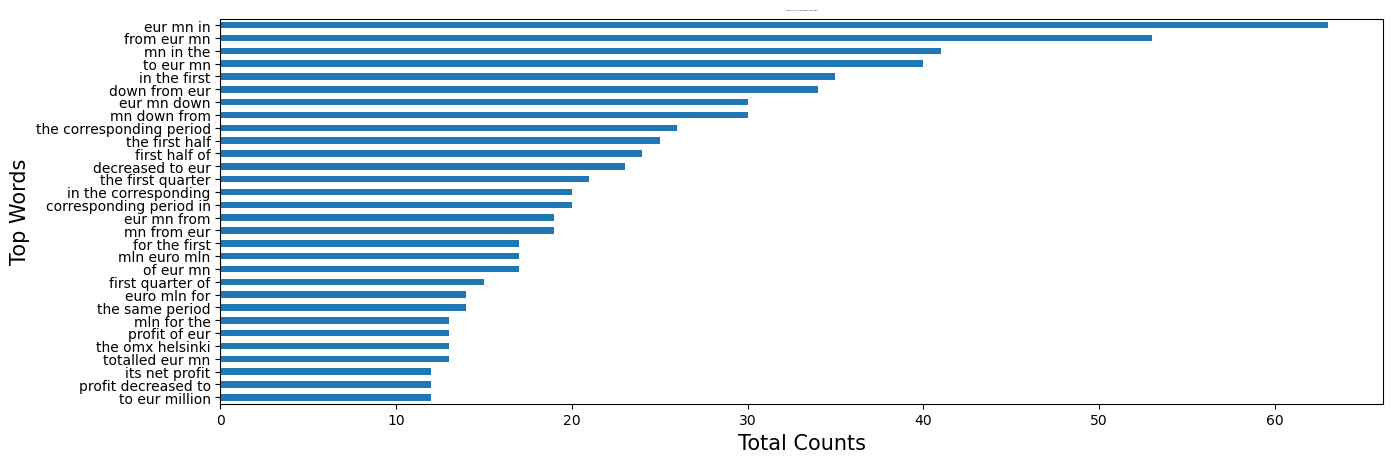

In [89]:
Trigram_processed_negative_data.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", figsize = (15, 5))
plt.title("3-gram of Reviews with Negative Sentiments", loc = "center", fontsize = 1)
plt.xlabel("Total Counts", fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15)
plt.show()

In [90]:
words_p = Gram_Analysis(neutral_processed_finance["Sentence"], 3, 30)
Trigram_processed_neutral_data = pd.DataFrame(words_p, columns = ["Words", "Counts"])
Trigram_processed_neutral_data

Words  Counts
0           as well as      64
1            eur mn in      47
2         value of the      45
3         net sales of      42
4         mln euro mln      42
5           the end of      39
6     the company said      36
7          part of the      33
8        profit of eur      32
9   board of directors      32
10           of eur mn      32
11        the value of      31
12      of the company      29
13           to eur mn      29
14           mn in the      28
15      is expected to      25
16       the number of      25
17        the board of      24
18        sales of eur      22
19   the third quarter      22
20      of eur million      20
21          is part of      20
22      mn compared to      20
23    according to the      19
24       in the second      19
25  the second quarter      19
26     eur mn compared      19
27          by the end      18
28       eur per share      18
29   second quarter of      17

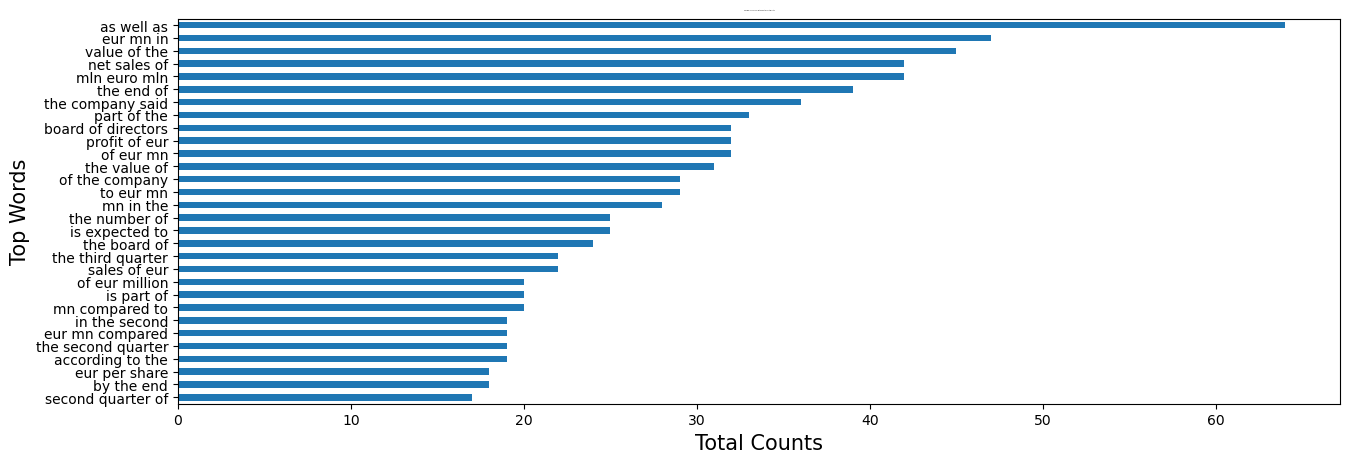

In [91]:
Trigram_processed_neutral_data.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", figsize = (15, 5))
plt.title("3-gram of Reviews with neutral Sentiments", loc = "center", fontsize = 1)
plt.xlabel("Total Counts", fontsize = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", fontsize = 15)
plt.show()

In [92]:
Trigram_df = pd.DataFrame({'positive_words': Trigram_processed_positive_data['Words'], 'Negative_bigrams': Trigram_processed_negative_data['Words'], 'neutral_bigrams': Trigram_processed_neutral_data['Words']})
Trigram_df

positive_words          Negative_bigrams     neutral_bigrams
0                from eur mn                 eur mn in          as well as
1                  eur mn in               from eur mn           eur mn in
2                  to eur mn                 mn in the        value of the
3   the corresponding period                 to eur mn        net sales of
4                  mn in the              in the first        mln euro mln
5    corresponding period in             down from eur          the end of
6                eur mn from               eur mn down    the company said
7                mn from eur              mn down from         part of the
8                rose to eur  the corresponding period       profit of eur
9       in the corresponding            the first half  board of directors
10              mln euro mln             first half of           of eur mn
11               up from eur          decreased to eur        the value of
12            profit rose to         the first quarter      of the company
13                 eur mn up      in the corresponding           to eur mn
14                mn up from   corresponding period in           mn in the
15              in the first               eur mn from      is expected to
16            to eur million               mn from eur       the number of
17           the same period                 of eur mn        the board of
18                 by to eur              mln euro mln        sales of eur
19              year on year             for the first   the third quarter
20               loss of eur          first quarter of      of eur million
21        the second quarter              euro mln for          is part of
22          from eur million           the same period      mn compared to
23                 of eur mn           totalled eur mn    according to the
24            nine months of             profit of eur       in the second
25         the first quarter          the omx helsinki  the second quarter
26            the first nine               mln for the     eur mn compared
27         first nine months            its net profit          by the end
28         second quarter of            to eur million       eur per share
29         the third quarter       profit decreased to   second quarter of

* The trigram analysis also shows the similar inference form the bigram analysis that most of the words are common english words and currency and some period related terms which do not contribute to the sentiments

#### From the analysis carried over we can find that the company names and period names and some of the common words are to be removed as they do not contribute to the sentiments , which infers that they may be present in sentences containing different ssentiments

In [93]:
Stopwords.remove('not')

In [94]:
Stopwords.remove('down')

In [95]:
Stopwords.remove('more')

In [96]:
Stopwords.remove('under')

In [97]:
Stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan'

### Further stop words to be removed based on diiferent prespectives

In [98]:
domain_words=['finnish','russian','finland','russia','swedish','firm','eighteen','months','taking','total','square',
              'eur','million','announcement','day','earlier','glaston','net','third','quarter','dropped','mln','euro',
              'period','april','baltic','countries','eur mn','last','year','million','state',
              'office','msft','orcl','goog','crm','adbe','aapl','afternoon','esi','billion','eurm','third','quarter',
              'half','annually','annualy','first','second','nine','helsinki','omx','year','month','day','indian','india','third'
              ,'fourth','mn','mln','in','eur','euro','months','goods','one','the', 'of', 'in', 'to', 'and', 'a','eur', 'for',
              's', 'is', 'on', 'from', 'will', 'company', 'as', 'mn', 'its', 'with', 'by', 'be', 'has', 'at','it', 'said', 
              'million', 'net', 'year', 'm', 'that', 'was', 'group', 'an', 'mln','new', 'are', 'quarter','this', 'oyj','also',
              'have', 'which', 'first', 'euro', 'today', 'been', 'about', 'helsinki', 'per','total', 'after', 'nokia', 'bank', 
              'based', 'were', 'we', 'than', 'some','or', 'other', 'all', 'one', 'hel' ,'our', 'plc', 'now', 'last', 'their',
              'second', 'ceo', 'pct', 'january', 'into', 'aapl', 'would', 'eurm', 'out', 'part', 'oy','i','september', 'usd',
              'two', 'third','earlier', 'can', 'time', 'billion','had', 'omx','us', 'russia', 'may','annual', 'day', 'both', 
              'tsla','while', 'before','months', 'number', 'march', 'october', 'euros',
              'they','through', 'april']

* these domain words consists of the names of companies , currencies , trems reffering period,and some share names and also some general words which do not contribute to the sentiments

In [99]:
Stopwords.update(domain_words)

In [100]:
Stopwords

{'a',
 'aapl',
 'about',
 'above',
 'adbe',
 'after',
 'afternoon',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'announcement',
 'annual',
 'annually',
 'annualy',
 'any',
 'april',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'baltic',
 'bank',
 'based',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'billion',
 'both',
 'but',
 'by',
 'can',
 'ceo',
 'company',
 'couldn',
 "couldn't",
 'countries',
 'crm',
 'd',
 'day',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'dropped',
 'during',
 'each',
 'earlier',
 'eighteen',
 'esi',
 'eur',
 'eur mn',
 'eurm',
 'euro',
 'euros',
 'few',
 'finland',
 'finnish',
 'firm',
 'first',
 'for',
 'fourth',
 'from',
 'further',
 'glaston',
 'goods',
 'goog',
 'group',
 'had',
 'hadn',
 "hadn't",
 'half',
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'hel',
 'helsinki',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'hims

###  since we have formulated the stopwords from the existing dataset 
* now we have to remove these stopwords and for this since we are removing the stop words individually each word is tokenized that is each word split a single word
* there is possibility that many of the words may present in diiferent gramaticial format and they are convert into their root words by the process of lematization

In [101]:
def Text_Processing(Text):    
    Processed_Text = list()
    Lemmatizer = WordNetLemmatizer()

    # Tokens of Words
    Tokens = nltk.word_tokenize(Text)

    for word in Tokens:
        if word not in Stopwords:            
            Processed_Text.append(Lemmatizer.lemmatize(word))            
    return(" ".join(Processed_Text))

In [102]:
cleaned_finance_data=finance_sentiments

In [103]:
cleaned_finance_data["Sentence"]=cleaned_finance_data["Sentence"].apply(Text_Processing)
cleaned_finance_data

Sentence Sentiment  polarity
0     geosolutions technology leverage benefon gps s...  positive    0.2091
1                          low down bk real possibility  negative    0.0222
2     componenta sale doubled moved zero pre tax pro...  positive    0.0000
3     according chamber commerce major construction ...   neutral    0.0625
4     buyout sold remaining percent stake almost public   neutral   -0.1000
...                                                 ...       ...       ...
5448              medium talentum issued profit warning   neutral    0.0000
5472  largest restructuring planned italy negotiatio...   neutral    0.0000
5550  negotiation resulted reduction people regular ...  negative   -0.0833
5570                passenger flew airline down percent  negative   -0.0778
5634                       sale decreased corresponding  negative   -0.2000

[5322 rows x 3 columns]

In [104]:
cleaned_finance_data=cleaned_finance_data.drop(columns='polarity')
cleaned_finance_data

Sentence Sentiment
0     geosolutions technology leverage benefon gps s...  positive
1                          low down bk real possibility  negative
2     componenta sale doubled moved zero pre tax pro...  positive
3     according chamber commerce major construction ...   neutral
4     buyout sold remaining percent stake almost public   neutral
...                                                 ...       ...
5448              medium talentum issued profit warning   neutral
5472  largest restructuring planned italy negotiatio...   neutral
5550  negotiation resulted reduction people regular ...  negative
5570                passenger flew airline down percent  negative
5634                       sale decreased corresponding  negative

[5322 rows x 2 columns]

In [105]:
cleaned_finance_data.to_csv('processed_Financial_dataset.csv',index= False)

# =============================================================

### Checking for the polarity score between the cleaned data and uncleaned data

In [106]:
finance_check=pd.read_csv("financial_sentiment_data.csv")
finance_check

Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5842 rows x 2 columns]

In [107]:
finance_check['polarity']=(round(finance_check['Sentence'].apply(lambda x:TextBlob(x).sentiment.polarity),4))
finance_check

Sentence Sentiment  polarity
0     The GeoSolutions technology will leverage Bene...  positive    0.2091
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative    0.0222
2     For the last quarter of 2010 , Componenta 's n...  positive    0.0000
3     According to the Finnish-Russian Chamber of Co...   neutral    0.0625
4     The Swedish buyout firm has sold its remaining...   neutral   -0.1000
...                                                 ...       ...       ...
5837  RISING costs have forced packaging producer Hu...  negative   -0.3000
5838  Nordic Walking was first used as a summer trai...   neutral    0.2500
5839  According shipping company Viking Line , the E...   neutral    0.1875
5840  In the building and home improvement trade , s...   neutral   -0.4000
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive    0.2500

[5842 rows x 3 columns]

In [108]:
finance_check['clean_Sentence']=finance_check['Sentence'].apply(text_cleaning).apply(Text_Processing)

In [109]:
finance_check['cleaned_polarity']=(round(finance_check['clean_Sentence'].apply(lambda x:TextBlob(x).sentiment.polarity),4))
finance_check

Sentence Sentiment  polarity  \
0     The GeoSolutions technology will leverage Bene...  positive    0.2091   
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative    0.0222   
2     For the last quarter of 2010 , Componenta 's n...  positive    0.0000   
3     According to the Finnish-Russian Chamber of Co...   neutral    0.0625   
4     The Swedish buyout firm has sold its remaining...   neutral   -0.1000   
...                                                 ...       ...       ...   
5837  RISING costs have forced packaging producer Hu...  negative   -0.3000   
5838  Nordic Walking was first used as a summer trai...   neutral    0.2500   
5839  According shipping company Viking Line , the E...   neutral    0.1875   
5840  In the building and home improvement trade , s...   neutral   -0.4000   
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive    0.2500   

                                         clean_Sentence  cleaned_polarity  
0     geosolutions technology leverage benefon gps s...            0.2333  
1                          low down bk real possibility            0.0148  
2     componenta sale doubled moved zero pre tax pro...            0.0000  
3     according chamber commerce major construction ...            0.0625  
4     buyout sold remaining percent stake almost public            0.0000  
...                                                 ...               ...  
5837  rising cost forced packaging producer huhtamak...           -0.3000  
5838  nordic walking used summer training method cro...            0.0000  
5839  according shipping viking line eu decision sig...            0.1875  
5840     building home improvement trade sale decreased           -0.4000  
5841  afx kci konecranes order four hot metal ladle ...            0.2500  

[5842 rows x 5 columns]

In [110]:
finance_check["diff_in_polarity"]=abs(finance_check["polarity"]-finance_check["cleaned_polarity"])
finance_check

Sentence Sentiment  polarity  \
0     The GeoSolutions technology will leverage Bene...  positive    0.2091   
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative    0.0222   
2     For the last quarter of 2010 , Componenta 's n...  positive    0.0000   
3     According to the Finnish-Russian Chamber of Co...   neutral    0.0625   
4     The Swedish buyout firm has sold its remaining...   neutral   -0.1000   
...                                                 ...       ...       ...   
5837  RISING costs have forced packaging producer Hu...  negative   -0.3000   
5838  Nordic Walking was first used as a summer trai...   neutral    0.2500   
5839  According shipping company Viking Line , the E...   neutral    0.1875   
5840  In the building and home improvement trade , s...   neutral   -0.4000   
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive    0.2500   

                                         clean_Sentence  cleaned_polarity  \
0     geosolutions technology leverage benefon gps s...            0.2333   
1                          low down bk real possibility            0.0148   
2     componenta sale doubled moved zero pre tax pro...            0.0000   
3     according chamber commerce major construction ...            0.0625   
4     buyout sold remaining percent stake almost public            0.0000   
...                                                 ...               ...   
5837  rising cost forced packaging producer huhtamak...           -0.3000   
5838  nordic walking used summer training method cro...            0.0000   
5839  according shipping viking line eu decision sig...            0.1875   
5840     building home improvement trade sale decreased           -0.4000   
5841  afx kci konecranes order four hot metal ladle ...            0.2500   

      diff_in_polarity  
0               0.0242  
1               0.0074  
2               0.0000  
3               0.0000  
4               0.1000  
...                ...  
5837            0.0000  
5838            0.2500  
5839            0.0000  
5840            0.0000  
5841            0.0000  

[5842 rows x 6 columns]

# Visualization of the polarity scores

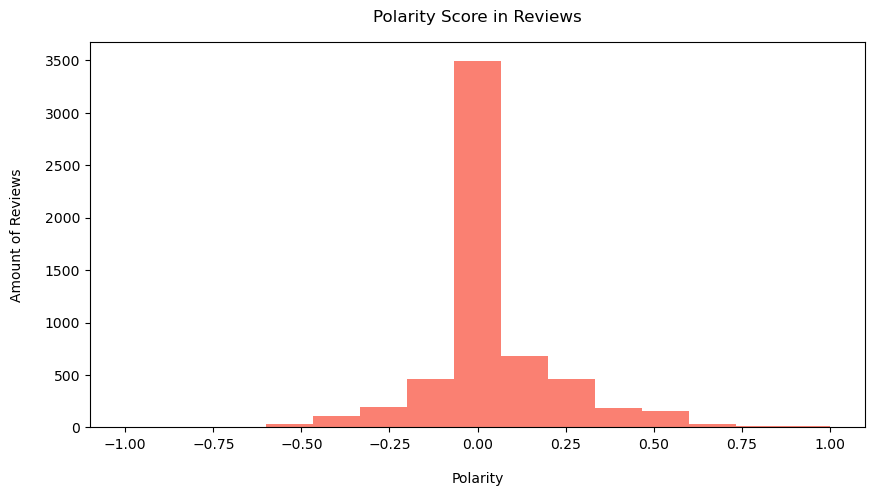

In [111]:
#Polarity scores
finance_check["polarity"].plot(kind = "hist", bins = 15, linewidth = 1, color = "salmon", figsize = (10,5))

plt.title("Polarity Score in Reviews", pad = 15)
plt.xlabel("Polarity", labelpad = 15)
plt.ylabel("Amount of Reviews", labelpad = 15)
plt.show()

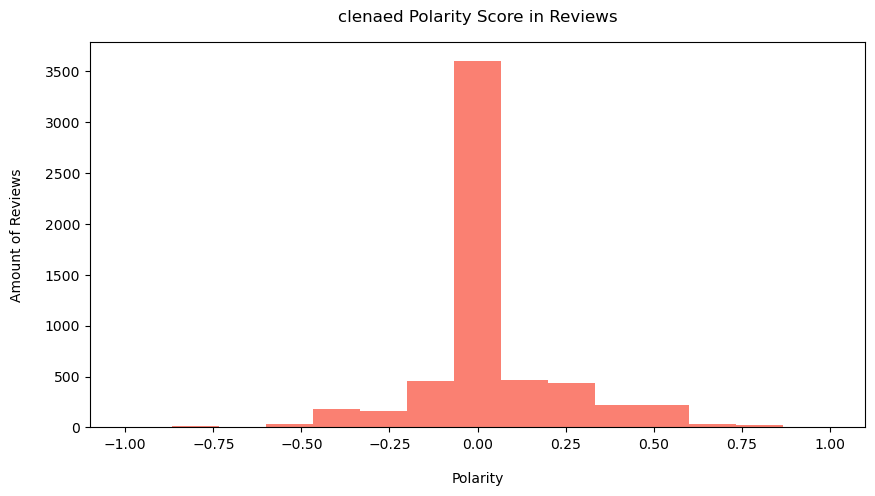

In [112]:
#Polarity scores
finance_check["cleaned_polarity"].plot(kind = "hist", bins = 15, linewidth = 1, color = "salmon", figsize = (10,5))

plt.title("clenaed Polarity Score in Reviews", pad = 15)
plt.xlabel("Polarity", labelpad = 15)
plt.ylabel("Amount of Reviews", labelpad = 15)
plt.show()

In [113]:
changed_datas=finance_check[finance_check["diff_in_polarity"]>0.5]

In [114]:
changed_datas.shape

(18, 6)

In [115]:
changed_datas

Sentence Sentiment  polarity  \
354   Some 3.8 mln euro ( $ 5.2 mln ) of the base ac...   neutral   -0.2212   
576   `` We know there are some of our own people ou...   neutral    0.6000   
764   Metsa-Botnia will finance the payment of divid...   neutral    0.6000   
1044  Sony Ericsson and Nokia dominated the list of ...  positive    0.0000   
1080  Biohit said that it will reduce the number of ...   neutral    0.6000   
1208  After 1 April 2007 Cencorp will not have any o...   neutral    0.6000   
1470  Trading code : ELI1V Number of shares : 99,483...   neutral    0.0333   
1569        $NFLX and $TSLA making all kinds of gains 📈  positive    0.0000   
1804  The deal will have no significant effect on th...   neutral   -0.1875   
2113  $FB bot some @78.47 breakout from the consolid...  positive    1.0000   
2440  Biohit said that it will reduce the number of ...  negative    0.6000   
2545  Pentik+ñinen emphasises that the most of the i...   neutral    0.4500   
2793  F-Secure Internet Security 2010 is a security ...   neutral   -0.1250   
2880  SWOT analysis is just one method of categoriza...   neutral    0.6000   
3326  As with other stakeholders , COMPTEL has been ...   neutral    0.4375   
3816  City CU Welcomes DART Members DALLAS-City CU w...   neutral    0.0000   
4327  Founded in 1923 , Finnair is one of the world ...   neutral    0.0000   
4372  Raisio 's bid to buy Glisten is a `` win-win '...  positive   -0.2000   

                                         clean_Sentence  cleaned_polarity  \
354   base acquisition price paid cash rest subscrip...            -0.800   
576                                         know people             0.000   
764   metsa botnia finance payment dividend repaymen...             0.000   
1044  sony ericsson dominated list best selling hand...             1.000   
1080       biohit reduce leased personnel lay personnel             0.000   
1208                     cencorp not employee territory             0.000   
1470  trading code eliv share price share gratuitous...            -0.500   
1569                              nflx making kind gain             0.600   
1804     deal significant effect acquiring equity ratio             0.375   
2113                 fb bot breakout consolidation zone             0.000   
2440       biohit reduce leased personnel lay personnel             0.000   
2545  pentik inen emphasis internet content medium h...            -0.200   
2793  f secure internet security security service su...             0.400   
2880       swot analysis method categorization weakness             0.000   
3326  stakeholder comptel involved workshop meeting ...             1.000   
3816  city cu welcome dart member dallas city cu wel...             0.800   
4327  founded finnair world oldest airline fly desti...             0.800   
4372  raisio bid buy glisten win win deal company ch...             0.800   

      diff_in_polarity  
354             0.5788  
576             0.6000  
764             0.6000  
1044            1.0000  
1080            0.6000  
1208            0.6000  
1470            0.5333  
1569            0.6000  
1804            0.5625  
2113            1.0000  
2440            0.6000  
2545            0.6500  
2793            0.5250  
2880            0.6000  
3326            0.5625  
3816            0.8000  
4327            0.8000  
4372            1.0000

* by reading the difference in the polarity score between the statements mannually for the statements making bigger difference we can find the change in the polarity score is in mannner that the sentiments are not changed

# Model Building and Model Evaluation

# 1.Tf-idf  (Unbalanced Dataset)

In [117]:
finance_model_data=pd.read_csv("processed_Financial_dataset.csv")
finance_model_data

Sentence Sentiment
0     geosolutions technology leverage benefon gps s...  positive
1                          low down bk real possibility  negative
2     componenta sale doubled moved zero pre tax pro...  positive
3     according chamber commerce major construction ...   neutral
4     buyout sold remaining percent stake almost public   neutral
...                                                 ...       ...
5317              medium talentum issued profit warning   neutral
5318  largest restructuring planned italy negotiatio...   neutral
5319  negotiation resulted reduction people regular ...  negative
5320                passenger flew airline down percent  negative
5321                       sale decreased corresponding  negative

[5322 rows x 2 columns]

In [118]:
finance_model_data.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [119]:
tfidf=TfidfVectorizer()

In [120]:
X=tfidf.fit_transform(finance_model_data['Sentence'])

In [121]:
X.shape

(5322, 8955)

In [122]:
y=le.fit_transform(finance_model_data["Sentiment"])

In [123]:
#Balance the imbalanced dataset  0-negative  1-neutral  2- positive
Counter(y)

Counter({2: 1852, 0: 656, 1: 2814})

In [124]:
#Model Selection
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Support Vector Machine

In [125]:
SV_tfidf_un = SVC()

In [126]:
SV_tfidf_un.fit(X_train, y_train)

SVC()

In [127]:
y_pred_SV = SV_tfidf_un.predict(X_test)
print(classification_report(y_test, y_pred_SV))

              precision    recall  f1-score   support

           0       0.93      0.30      0.46       136
           1       0.71      0.94      0.80       575
           2       0.74      0.54      0.62       354

    accuracy                           0.72      1065
   macro avg       0.79      0.59      0.63      1065
weighted avg       0.75      0.72      0.70      1065



In [128]:
confusion_matrix(y_test, y_pred_SV)

array([[ 41,  64,  31],
       [  1, 538,  36],
       [  2, 161, 191]], dtype=int64)

In [129]:
y_train_pred_SV = SV_tfidf_un.predict(X_train)
print(classification_report(y_train, y_train_pred_SV))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       520
           1       0.97      0.99      0.98      2239
           2       0.98      0.98      0.98      1498

    accuracy                           0.98      4257
   macro avg       0.98      0.96      0.97      4257
weighted avg       0.98      0.98      0.98      4257



### Random Forest Classifier

In [131]:
RandomForest_tfidf_un = RandomForestClassifier()
RandomForest_tfidf_un.fit(X_train, y_train)

RandomForestClassifier()

In [132]:
y_pred_RF = RandomForest_tfidf_un.predict(X_test)
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.77      0.40      0.53       136
           1       0.74      0.91      0.82       575
           2       0.74      0.60      0.66       354

    accuracy                           0.74      1065
   macro avg       0.75      0.64      0.67      1065
weighted avg       0.74      0.74      0.73      1065



In [133]:
confusion_matrix(y_test, y_pred_RF)

array([[ 55,  48,  33],
       [ 10, 524,  41],
       [  6, 136, 212]], dtype=int64)

In [134]:
y_train_pred_RF = RandomForest_tfidf_un.predict(X_train)
print(classification_report(y_train, y_train_pred_RF))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00      2239
           2       1.00      1.00      1.00      1498

    accuracy                           1.00      4257
   macro avg       1.00      1.00      1.00      4257
weighted avg       1.00      1.00      1.00      4257



# Multinomial navie bayes

In [135]:
Multinomial_tfidf_un =  MultinomialNB()
Multinomial_tfidf_un.fit(X_train, y_train)

MultinomialNB()

In [136]:
y_pred_M = Multinomial_tfidf_un.predict(X_test)
print(classification_report(y_test, y_pred_M))

              precision    recall  f1-score   support

           0       0.80      0.03      0.06       136
           1       0.71      0.92      0.80       575
           2       0.65      0.56      0.60       354

    accuracy                           0.69      1065
   macro avg       0.72      0.51      0.49      1065
weighted avg       0.70      0.69      0.64      1065



In [137]:
confusion_matrix(y_test, y_pred_M)

array([[  4,  68,  64],
       [  0, 531,  44],
       [  1, 154, 199]], dtype=int64)

In [138]:
y_train_pred_M = Multinomial_tfidf_un.predict(X_train)
print(classification_report(y_train, y_train_pred_M))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       520
           1       0.80      0.97      0.87      2239
           2       0.81      0.78      0.79      1498

    accuracy                           0.81      4257
   macro avg       0.87      0.64      0.66      4257
weighted avg       0.83      0.81      0.78      4257



# 2. Word2vec Model(Unbalanced dataset)


In [142]:
finance_df=pd.read_csv("processed_Financial_dataset.csv")
finance_df

Sentence Sentiment
0     geosolutions technology leverage benefon gps s...  positive
1                          low down bk real possibility  negative
2     componenta sale doubled moved zero pre tax pro...  positive
3     according chamber commerce major construction ...   neutral
4     buyout sold remaining percent stake almost public   neutral
...                                                 ...       ...
5317              medium talentum issued profit warning   neutral
5318  largest restructuring planned italy negotiatio...   neutral
5319  negotiation resulted reduction people regular ...  negative
5320                passenger flew airline down percent  negative
5321                       sale decreased corresponding  negative

[5322 rows x 2 columns]

In [143]:
wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

In [144]:
print(vec_king.shape)
vec_king

(300,)


array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [146]:
words=[]
for sent in finance_df['Sentence']:
    sent_token=sent_tokenize(sent)
    for sent in sent_token:
        words.append(simple_preprocess(sent))

In [147]:
words

[['geosolutions',
  'technology',
  'leverage',
  'benefon',
  'gps',
  'solution',
  'providing',
  'location',
  'search',
  'technology',
  'community',
  'platform',
  'location',
  'relevant',
  'multimedia',
  'content',
  'powerful',
  'commercial',
  'model'],
 ['low', 'down', 'bk', 'real', 'possibility'],
 ['componenta',
  'sale',
  'doubled',
  'moved',
  'zero',
  'pre',
  'tax',
  'profit',
  'pre',
  'tax',
  'loss'],
 ['according',
  'chamber',
  'commerce',
  'major',
  'construction',
  'company',
  'operating'],
 ['buyout', 'sold', 'remaining', 'percent', 'stake', 'almost', 'public'],
 ['spy', 'surprised', 'see', 'green', 'close'],
 ['shell', 'bg', 'deal', 'meet', 'shareholder', 'skepticism'],
 ['kone', 'sale', 'rose'],
 ['stockmann',
  'department',
  'store',
  'floor',
  'space',
  'metre',
  'stockmann',
  'investment',
  'project',
  'price',
  'tag'],
 ['circulation', 'revenue', 'increased', 'sweden'],
 ['sap',
  'disappoints',
  'software',
  'license',
  'down'

In [148]:
model=gensim.models.Word2Vec(words)

In [149]:
model.wv.index_to_key

['sale',
 'share',
 'profit',
 'market',
 'service',
 'operating',
 'business',
 'price',
 'loss',
 'product',
 'operation',
 'contract',
 'solution',
 'down',
 'stock',
 'compared',
 'percent',
 'plant',
 'order',
 'unit',
 'system',
 'not',
 'financial',
 'customer',
 'investment',
 'technology',
 'corresponding',
 'corporation',
 'result',
 'long',
 'capital',
 'mobile',
 'project',
 'more',
 'well',
 'report',
 'value',
 'according',
 'increase',
 'production',
 'increased',
 'deal',
 'company',
 'rose',
 'agreement',
 'board',
 'industry',
 'area',
 'building',
 'construction',
 'buy',
 'end',
 'network',
 'line',
 'high',
 'expected',
 'development',
 'growth',
 'short',
 'term',
 'cost',
 'acquisition',
 'sell',
 'paper',
 'revenue',
 'medium',
 'dividend',
 'under',
 'right',
 'director',
 'earnings',
 'maker',
 'equipment',
 'decreased',
 'management',
 'news',
 'employee',
 'global',
 'stake',
 'plan',
 'approximately',
 'offer',
 'option',
 'real',
 'exchange',
 'data',
 'so

In [150]:
model.corpus_count

5322

In [151]:
model.epochs

5

In [152]:
model.wv.similar_by_word("profit")

[('loss', 0.999263346195221),
 ('corresponding', 0.9989468455314636),
 ('compared', 0.9988003969192505),
 ('increased', 0.9987716674804688),
 ('sale', 0.998508095741272),
 ('decreased', 0.998436689376831),
 ('operating', 0.9984053373336792),
 ('rose', 0.9983744025230408),
 ('june', 0.9983335733413696),
 ('item', 0.9979273080825806)]

In [153]:
model.wv['profit'].shape

(100,)

In [154]:
words[1]

['low', 'down', 'bk', 'real', 'possibility']

* Each word in Vectorized into 100dimensional vector but for sentiment classification we have to find represetnation of the sentence 
* for this sentiment classification we can take average of all the vectors of a particualr sentence and create a df

In [155]:
def avg_word2vec(text):
    
    return np.mean([model.wv[word]for word in text if word in model.wv.index_to_key],axis=0)

In [156]:
#apply for the entire sentences
from tqdm import tqdm
import numpy as np
X=[]
for i in tqdm(range(len(words))):
    X.append(avg_word2vec(words[i]))

100%|████████████████████████████████████████████████████████████████████████████| 5322/5322 [00:01<00:00, 3804.60it/s]


In [157]:
len(X)

5322

In [158]:
finance_df.shape

(5322, 2)

In [159]:
X[1]

array([-0.20710166,  0.2633207 ,  0.06395245,  0.08962614,  0.15112972,
       -0.5255466 ,  0.01018004,  0.6357584 , -0.11136335, -0.17399526,
       -0.09334134, -0.42535982, -0.10269435,  0.1462006 ,  0.07281312,
       -0.3280652 ,  0.14220397, -0.29160038, -0.02541574, -0.45361567,
        0.35459247,  0.14085253,  0.08492879, -0.10983651, -0.08672076,
        0.00249134, -0.28310183, -0.21567877, -0.38571802,  0.1062158 ,
        0.29418603,  0.10690176, -0.09102491, -0.2945947 , -0.03709831,
        0.26931956, -0.08244202, -0.3871911 , -0.16640176, -0.57589173,
        0.00431056, -0.24359302, -0.05172342,  0.0397322 ,  0.25863835,
       -0.16752018, -0.23975742, -0.04698284,  0.09328834,  0.23502137,
        0.1570813 , -0.29140577, -0.28774515, -0.06789472, -0.17461847,
        0.2727221 ,  0.22746265,  0.08978494, -0.37748834,  0.1351241 ,
        0.01619262,  0.10958583, -0.16032957, -0.03518982, -0.37720278,
        0.273533  ,  0.05652921,  0.26839834, -0.3809112 ,  0.35

In [160]:
y=le.fit_transform(finance_df["Sentiment"])

In [161]:
y.shape

(5322,)

In [162]:
Counter(y)   #this shows the 2-positive  1-neutral  0- negative

Counter({2: 1852, 0: 656, 1: 2814})

In [163]:
X[0].reshape(1,-1).shape

(1, 100)

In [164]:
## this is the final independent features
df=pd.DataFrame()
for i in range(0,len(X)):
    df=df.append(pd.DataFrame(X[i].reshape(1,-1)),ignore_index=True)

In [165]:
df.head()

0         1         2         3         4         5         6   \
0 -0.127691  0.166676  0.044364  0.060903  0.096914 -0.340787  0.003594   
1 -0.207102  0.263321  0.063952  0.089626  0.151130 -0.525547  0.010180   
2 -0.132230  0.164021  0.038152  0.061134  0.089723 -0.328076  0.013395   
3 -0.233745  0.296166  0.070524  0.103603  0.168530 -0.613073  0.014931   
4 -0.125762  0.164460  0.044404  0.061561  0.098615 -0.341372  0.004479   

         7         8         9   ...        90        91        92        93  \
0  0.415970 -0.065685 -0.117612  ...  0.289373  0.075618  0.084288  0.051997   
1  0.635758 -0.111363 -0.173995  ...  0.452513  0.124207  0.122935  0.070364   
2  0.401719 -0.078165 -0.111822  ...  0.277381  0.078466  0.076295  0.042715   
3  0.743547 -0.131855 -0.206825  ...  0.519740  0.139618  0.140985  0.084854   
4  0.407980 -0.067878 -0.114075  ...  0.288028  0.075982  0.086518  0.054672   

         94        95        96        97        98        99  
0  0.343116  0.180403  0.064611 -0.248386  0.061826 -0.030880  
1  0.528176  0.283933  0.106378 -0.380479  0.097357 -0.045112  
2  0.344058  0.189259  0.064780 -0.241732  0.067651 -0.037447  
3  0.623302  0.330488  0.117688 -0.447417  0.107215 -0.063592  
4  0.338495  0.179322  0.061698 -0.249973  0.061842 -0.028387  

[5 rows x 100 columns]

In [166]:
df.shape

(5322, 100)

In [167]:
df['Output']=y
df.shape

(5322, 101)

In [168]:
df.isnull().sum()

0         8
1         8
2         8
3         8
4         8
         ..
96        8
97        8
98        8
99        8
Output    0
Length: 101, dtype: int64

In [169]:
df.dropna(inplace=True)

In [170]:
df.shape

(5314, 101)

In [171]:
df.isnull().sum()

0         0
1         0
2         0
3         0
4         0
         ..
96        0
97        0
98        0
99        0
Output    0
Length: 101, dtype: int64

In [172]:
X_wv=df.iloc[:,:-1]

In [173]:
X_wv

0         1         2         3         4         5         6   \
0    -0.127691  0.166676  0.044364  0.060903  0.096914 -0.340787  0.003594   
1    -0.207102  0.263321  0.063952  0.089626  0.151130 -0.525547  0.010180   
2    -0.132230  0.164021  0.038152  0.061134  0.089723 -0.328076  0.013395   
3    -0.233745  0.296166  0.070524  0.103603  0.168530 -0.613073  0.014931   
4    -0.125762  0.164460  0.044404  0.061561  0.098615 -0.341372  0.004479   
...        ...       ...       ...       ...       ...       ...       ...   
5317 -0.144273  0.181969  0.040133  0.067290  0.101873 -0.365223  0.009823   
5318 -0.097939  0.125128  0.035383  0.046019  0.074583 -0.261476  0.005320   
5319 -0.092284  0.118221  0.031302  0.047154  0.070517 -0.242660  0.000743   
5320 -0.176003  0.222158  0.056260  0.081665  0.132101 -0.462885  0.006938   
5321 -0.214047  0.259717  0.056062  0.099692  0.142590 -0.524495  0.020260   

            7         8         9   ...        90        91        92  \
0     0.415970 -0.065685 -0.117612  ...  0.289373  0.075618  0.084288   
1     0.635758 -0.111363 -0.173995  ...  0.452513  0.124207  0.122935   
2     0.401719 -0.078165 -0.111822  ...  0.277381  0.078466  0.076295   
3     0.743547 -0.131855 -0.206825  ...  0.519740  0.139618  0.140985   
4     0.407980 -0.067878 -0.114075  ...  0.288028  0.075982  0.086518   
...        ...       ...       ...  ...       ...       ...       ...   
5317  0.445419 -0.087141 -0.124572  ...  0.311485  0.090639  0.091970   
5318  0.320669 -0.056496 -0.085843  ...  0.223809  0.058010  0.064237   
5319  0.300801 -0.050038 -0.082833  ...  0.207446  0.056718  0.058165   
5320  0.560745 -0.100460 -0.148607  ...  0.391920  0.107580  0.115825   
5321  0.636503 -0.134783 -0.168742  ...  0.449103  0.124834  0.115687   

            93        94        95        96        97        98        99  
0     0.051997  0.343116  0.180403  0.064611 -0.248386  0.061826 -0.030880  
1     0.070364  0.528176  0.283933  0.106378 -0.380479  0.097357 -0.045112  
2     0.042715  0.344058  0.189259  0.064780 -0.241732  0.067651 -0.037447  
3     0.084854  0.623302  0.330488  0.117688 -0.447417  0.107215 -0.063592  
4     0.054672  0.338495  0.179322  0.061698 -0.249973  0.061842 -0.028387  
...        ...       ...       ...       ...       ...       ...       ...  
5317  0.047795  0.383380  0.201628  0.073743 -0.269679  0.068060 -0.040943  
5318  0.039910  0.262309  0.140996  0.045221 -0.192275  0.045824 -0.024776  
5319  0.036662  0.247052  0.132033  0.043082 -0.180239  0.048100 -0.020527  
5320  0.067245  0.460635  0.249259  0.084038 -0.339612  0.080692 -0.041181  
5321  0.057553  0.544433  0.291742  0.109682 -0.388283  0.102538 -0.054296  

[5314 rows x 100 columns]

In [174]:
y_wv=df['Output']

In [175]:
## Train Test Split
X_train_un,X_test_un,y_train_un,y_test_un=train_test_split(X_wv,y_wv,test_size=0.25)

In [176]:
X_train_un.head()

0         1         2         3         4         5         6   \
2589 -0.102144  0.129414  0.033576  0.052378  0.079721 -0.266910  0.003432   
4760 -0.121710  0.160361  0.040353  0.062335  0.093601 -0.326592  0.003375   
294  -0.140709  0.180538  0.047550  0.068520  0.103926 -0.376331  0.004828   
2346 -0.158328  0.206485  0.052491  0.075935  0.119739 -0.426234  0.005487   
4557 -0.174014  0.224140  0.056599  0.088464  0.137141 -0.471217  0.008853   

            7         8         9   ...        90        91        92  \
2589  0.330972 -0.052095 -0.089662  ...  0.227232  0.062403  0.061845   
4760  0.393504 -0.067512 -0.109835  ...  0.273467  0.073194  0.082730   
294   0.456659 -0.073636 -0.127034  ...  0.317232  0.082210  0.086744   
2346  0.517676 -0.089484 -0.143553  ...  0.358624  0.096756  0.102280   
4557  0.572956 -0.095339 -0.158997  ...  0.396145  0.104589  0.115456   

            93        94        95        96        97        98        99  
2589  0.044500  0.274071  0.140402  0.054833 -0.198224  0.047540 -0.029485  
4760  0.050175  0.328663  0.173165  0.061535 -0.237925  0.055141 -0.029299  
294   0.053225  0.373196  0.198326  0.068887 -0.274219  0.067190 -0.038965  
2346  0.066243  0.424918  0.223981  0.081634 -0.310757  0.076376 -0.039249  
4557  0.072289  0.467838  0.251922  0.087733 -0.340558  0.085128 -0.042323  

[5 rows x 100 columns]

## Random Forest Classifier in Word2Vec

In [177]:
RF_wv_un=RandomForestClassifier()

In [178]:
RF_wv_un.fit(X_train_un,y_train_un)

RandomForestClassifier()

In [179]:
y_pred_un=RF_wv_un.predict(X_test_un)

In [180]:
print(accuracy_score(y_test_un,y_pred_un))
print(confusion_matrix(y_test_un,y_pred_un))

0.5628291948833709
[[ 16 105  50]
 [  3 588  92]
 [  3 328 144]]


In [181]:
print(classification_report(y_test_un,y_pred_un))

              precision    recall  f1-score   support

           0       0.73      0.09      0.17       171
           1       0.58      0.86      0.69       683
           2       0.50      0.30      0.38       475

    accuracy                           0.56      1329
   macro avg       0.60      0.42      0.41      1329
weighted avg       0.57      0.56      0.51      1329



In [182]:
y_train_pred_un = RF_wv_un.predict(X_train_un)
print(classification_report(y_train_un, y_train_pred_un))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       483
           1       1.00      1.00      1.00      2126
           2       1.00      1.00      1.00      1376

    accuracy                           1.00      3985
   macro avg       1.00      1.00      1.00      3985
weighted avg       1.00      1.00      1.00      3985



## XGBM

In [184]:
xgb_wv_un = xgb.XGBClassifier(objective = 'multi:softmax', seed=42)
xgb_wv_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [185]:
y_pred_un=xgb_wv_un.predict(X_test_un)

In [186]:
print(accuracy_score(y_test_un,y_pred_un))
print(confusion_matrix(y_test_un,y_pred_un))

0.5748683220466516
[[ 30  87  54]
 [ 13 556 114]
 [ 19 278 178]]


In [187]:
print(classification_report(y_test_un,y_pred_un))

              precision    recall  f1-score   support

           0       0.48      0.18      0.26       171
           1       0.60      0.81      0.69       683
           2       0.51      0.37      0.43       475

    accuracy                           0.57      1329
   macro avg       0.53      0.45      0.46      1329
weighted avg       0.56      0.57      0.54      1329



In [188]:
y_train_pred_un = xgb_wv_un.predict(X_train_un)
print(classification_report(y_train_un, y_train_pred_un))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       483
           1       1.00      1.00      1.00      2126
           2       1.00      1.00      1.00      1376

    accuracy                           1.00      3985
   macro avg       1.00      1.00      1.00      3985
weighted avg       1.00      1.00      1.00      3985



# Balancing the unbalanced data using SMOTE ENN

# Word2vec model with balanced data

In [189]:
Counter(y)   #this shows the 2-positive  1-neutral  0- negative

Counter({2: 1852, 0: 656, 1: 2814})

In [190]:
smote = SMOTEENN(sampling_strategy={0: 2814, 1: 4500, 2: 3900},random_state=42)
X_resampled_wv, y_resampled_wv = smote.fit_resample(X_wv,y_wv)

In [191]:
X_train_resample_wv,X_test_resample_wv,y_train_resample_wv,y_test_resample_wv=train_test_split(X_resampled_wv,y_resampled_wv,test_size=0.25)

In [192]:
X_train_resample_wv.head()

0         1         2         3         4         5         6   \
2509 -0.175427  0.215052  0.041716  0.080031  0.119726 -0.425646  0.011498   
4725 -0.143137  0.180096  0.040723  0.065952  0.098860 -0.365233  0.007356   
3327 -0.186865  0.239647  0.073931  0.101417  0.138104 -0.491120  0.007892   
5331 -0.057874  0.077987  0.022584  0.026567  0.044569 -0.151786  0.002373   
7019 -0.125619  0.162361  0.044873  0.061726  0.095855 -0.330312  0.007379   

            7         8         9   ...        90        91        92  \
2509  0.520575 -0.111970 -0.137817  ...  0.362401  0.105751  0.098605   
4725  0.446966 -0.080604 -0.124465  ...  0.309256  0.089249  0.088321   
3327  0.597099 -0.104158 -0.164954  ...  0.420529  0.106064  0.127309   
5331  0.190718 -0.031466 -0.054503  ...  0.121768  0.036689  0.034723   
7019  0.394375 -0.074959 -0.111004  ...  0.276539  0.073971  0.081112   

            93        94        95        96        97        98        99  
2509  0.045629  0.443330  0.241181  0.093521 -0.316574  0.086912 -0.045970  
4725  0.051761  0.373338  0.200744  0.068461 -0.269991  0.067505 -0.035128  
3327  0.075938  0.489114  0.259954  0.089251 -0.361985  0.083582 -0.047254  
5331  0.027721  0.158868  0.086638  0.035100 -0.110862  0.023466 -0.010614  
7019  0.045871  0.327628  0.175266  0.062552 -0.242913  0.058863 -0.026622  

[5 rows x 100 columns]

In [193]:
Counter(y_resampled_wv)

Counter({0: 2618, 1: 2445, 2: 2624})

## Random Forest Classifier in Word2Vec

param_grid = {'n_estimators': [100, 200],'max_depth':range(10,15),'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(estimator=RF_wv_balanced,param_grid=param_grid, cv=3,verbose=10)
grid_search.fit(X_train_resample_wv,y_train_resample_wv)

grid_search.best_params_

In [195]:
RF_wv_balanced=RandomForestClassifier(n_estimators=200,criterion='entropy', max_depth= 14 )

In [196]:
RF_wv_balanced.fit(X_train_resample_wv,y_train_resample_wv)

RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=200)

In [197]:
y_pred_resample_wv=RF_wv_balanced.predict(X_test_resample_wv)

In [198]:

print(accuracy_score(y_test_resample_wv,y_pred_resample_wv))
print(confusion_matrix(y_test_resample_wv,y_pred_resample_wv))

0.9073881373569199
[[632   7  10]
 [ 22 531  61]
 [ 25  53 581]]


In [199]:
print(classification_report(y_test_resample_wv,y_pred_resample_wv))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       649
           1       0.90      0.86      0.88       614
           2       0.89      0.88      0.89       659

    accuracy                           0.91      1922
   macro avg       0.91      0.91      0.91      1922
weighted avg       0.91      0.91      0.91      1922



In [200]:
y_train_pred_resample_wv = RF_wv_balanced.predict(X_train_resample_wv)
print(classification_report(y_train_resample_wv, y_train_pred_resample_wv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1969
           1       1.00      1.00      1.00      1831
           2       1.00      1.00      1.00      1965

    accuracy                           1.00      5765
   macro avg       1.00      1.00      1.00      5765
weighted avg       1.00      1.00      1.00      5765



## XGBM

In [202]:
xgb_wv_balanced = xgb.XGBClassifier(objective = 'multi:softmax', seed=42)
xgb_wv_balanced.fit(X_train_resample_wv, y_train_resample_wv)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [203]:
y_pred_resample_wv=xgb_wv_balanced.predict(X_test_resample_wv)

In [204]:
print(accuracy_score(y_test_resample_wv,y_pred_resample_wv))
print(confusion_matrix(y_test_resample_wv,y_pred_resample_wv))

0.8850156087408949
[[617  11  21]
 [ 23 517  74]
 [ 38  54 567]]


In [205]:
print(classification_report(y_test_resample_wv,y_pred_resample_wv))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       649
           1       0.89      0.84      0.86       614
           2       0.86      0.86      0.86       659

    accuracy                           0.89      1922
   macro avg       0.88      0.88      0.88      1922
weighted avg       0.88      0.89      0.88      1922



In [206]:
y_train_pred_resample_wv = xgb_wv_balanced.predict(X_train_resample_wv)
print(classification_report(y_train_resample_wv, y_train_pred_resample_wv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1969
           1       1.00      1.00      1.00      1831
           2       1.00      1.00      1.00      1965

    accuracy                           1.00      5765
   macro avg       1.00      1.00      1.00      5765
weighted avg       1.00      1.00      1.00      5765



# ==============================================================

## Balancing the unbalanced data using SMOTE ENN


In [207]:
finance_datas=pd.read_csv("processed_Financial_dataset.csv")
finance_datas

Sentence Sentiment
0     geosolutions technology leverage benefon gps s...  positive
1                          low down bk real possibility  negative
2     componenta sale doubled moved zero pre tax pro...  positive
3     according chamber commerce major construction ...   neutral
4     buyout sold remaining percent stake almost public   neutral
...                                                 ...       ...
5317              medium talentum issued profit warning   neutral
5318  largest restructuring planned italy negotiatio...   neutral
5319  negotiation resulted reduction people regular ...  negative
5320                passenger flew airline down percent  negative
5321                       sale decreased corresponding  negative

[5322 rows x 2 columns]

In [208]:
tfidf_balanced=TfidfVectorizer()

In [209]:
X=tfidf_balanced.fit_transform(finance_datas['Sentence'])

In [210]:
X.shape

(5322, 8955)

In [211]:
y=le.fit_transform(finance_datas["Sentiment"])

In [212]:
y

array([2, 0, 2, ..., 0, 0, 0])

In [213]:
#Balance the imbalanced dataset  0-negative  1-neutral  2- positive
Counter(y)

Counter({2: 1852, 0: 656, 1: 2814})

In [214]:

smote_enn = SMOTEENN(sampling_strategy={0: 2814, 1: 4200, 2: 3500},random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [215]:
Counter(y_resampled)

Counter({0: 2730, 1: 2525, 2: 2477})

In [216]:
X_resampled.shape

(7732, 8955)

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
X_train_tfidf_balanced, X_test_tfidf_balanced, y_train_tfidf_balanced, y_test_tfidf_balanced = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 42)

In [219]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC

# svm

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics

svc_clf = SVC()

param_grid = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [0.1, 1, 10], 
              'gamma': ['scale', 'auto']}


grid_search = GridSearchCV(svc_clf, param_grid, cv=5,verbose=10)
grid_search.fit(X_train_tfidf_balanced, y_train_tfidf_balanced)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [220]:
svm_tfidf_balanced = SVC(C=10,gamma='scale',kernel='rbf')

In [221]:
svm_tfidf_balanced.fit(X_train_tfidf_balanced, y_train_tfidf_balanced)

SVC(C=10)

In [222]:
y_pred_svm_tfidf_balanced = svm_tfidf_balanced.predict(X_test_tfidf_balanced)
print(classification_report(y_test_tfidf_balanced, y_pred_svm_tfidf_balanced))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       574
           1       0.96      0.98      0.97       477
           2       0.98      0.96      0.97       496

    accuracy                           0.98      1547
   macro avg       0.98      0.98      0.98      1547
weighted avg       0.98      0.98      0.98      1547



In [223]:
confusion_matrix(y_test_tfidf_balanced, y_pred_svm_tfidf_balanced)

array([[572,   1,   1],
       [  1, 469,   7],
       [  2,  17, 477]], dtype=int64)

In [224]:
y_train_pred_svm_tfidf_balanced = svm_tfidf_balanced.predict(X_train_tfidf_balanced)
print(classification_report(y_train_tfidf_balanced, y_train_pred_svm_tfidf_balanced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2156
           1       1.00      1.00      1.00      2048
           2       1.00      1.00      1.00      1981

    accuracy                           1.00      6185
   macro avg       1.00      1.00      1.00      6185
weighted avg       1.00      1.00      1.00      6185



In [225]:
from sklearn.model_selection import cross_val_score

In [226]:
scores_SV = cross_val_score(svm_tfidf_balanced,X_resampled, y_resampled, cv=5)
scores_SV

array([0.98771816, 0.9896574 , 0.98447607, 0.99094437, 0.98382924])

## Random Forest Classifier

In [227]:
RF_tfidf_balanced = RandomForestClassifier()
RF_tfidf_balanced.fit(X_train_tfidf_balanced, y_train_tfidf_balanced)

RandomForestClassifier()

In [228]:
y_pred_RF_tfidf_balanced = RF_tfidf_balanced.predict(X_test_tfidf_balanced)
print(classification_report(y_test_tfidf_balanced, y_pred_RF_tfidf_balanced))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       574
           1       0.89      0.96      0.93       477
           2       0.97      0.90      0.93       496

    accuracy                           0.94      1547
   macro avg       0.94      0.94      0.94      1547
weighted avg       0.95      0.94      0.94      1547



In [229]:
confusion_matrix(y_test_tfidf_balanced, y_pred_RF_tfidf_balanced)

array([[557,  13,   4],
       [  6, 459,  12],
       [  9,  43, 444]], dtype=int64)

In [230]:
y_train_pred_RF_tfidf_balanced = RF_tfidf_balanced.predict(X_train_tfidf_balanced)
print(classification_report(y_train_tfidf_balanced, y_train_pred_RF_tfidf_balanced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2156
           1       1.00      1.00      1.00      2048
           2       1.00      1.00      1.00      1981

    accuracy                           1.00      6185
   macro avg       1.00      1.00      1.00      6185
weighted avg       1.00      1.00      1.00      6185



# Multinomial navie bayes

In [231]:
MN_tfidf_balanced =  MultinomialNB()
MN_tfidf_balanced.fit(X_train_tfidf_balanced, y_train_tfidf_balanced)

MultinomialNB()

In [232]:
y_pred_MN_tfidf_balanced = MN_tfidf_balanced.predict(X_test_tfidf_balanced)
print(classification_report(y_test_tfidf_balanced, y_pred_MN_tfidf_balanced))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       574
           1       0.93      0.91      0.92       477
           2       0.97      0.84      0.90       496

    accuracy                           0.92      1547
   macro avg       0.92      0.91      0.92      1547
weighted avg       0.92      0.92      0.92      1547



In [233]:
confusion_matrix(y_test_tfidf_balanced, y_pred_MN_tfidf_balanced)

array([[566,   7,   1],
       [ 31, 435,  11],
       [ 53,  25, 418]], dtype=int64)

In [234]:
y_train_pred_MN_tfidf_balanced = MN_tfidf_balanced.predict(X_train_tfidf_balanced)
print(classification_report(y_train_tfidf_balanced, y_train_pred_MN_tfidf_balanced))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2156
           1       0.96      0.94      0.95      2048
           2       0.97      0.90      0.94      1981

    accuracy                           0.95      6185
   macro avg       0.95      0.95      0.95      6185
weighted avg       0.95      0.95      0.95      6185



#  Collecting all the models in the dataframe


In [235]:
Models={'Models':['SVM_Tfidf_unbalanced','RF_Tfidf_unbalanced','Multi_navie_bayes_Tfidf_unbalanced'
                  ,'RF_WV_unbalanced','Xgboost_WV_unbalanced','RF_WV_Smoteenn','Xgboost_WV_Smoteenn',
                 'RF_Tfidf_Smoteenn','SVM_Tfidf_Smoteenn','Multi_navie_bayes_Tfidf_Smoteenn'],
        'Training Scores':[SV_tfidf_un.score(X_train, y_train),RandomForest_tfidf_un.score(X_train, y_train),
                        Multinomial_tfidf_un.score(X_train, y_train),RF_wv_un.score(X_train_un, y_train_un),
                        xgb_wv_un.score(X_train_un, y_train_un),RF_wv_balanced.score(X_train_resample_wv, y_train_resample_wv),
                        xgb_wv_balanced.score(X_train_resample_wv, y_train_resample_wv),
                        RF_tfidf_balanced.score(X_train_tfidf_balanced, y_train_tfidf_balanced),
                        svm_tfidf_balanced.score(X_train_tfidf_balanced, y_train_tfidf_balanced),
                        MN_tfidf_balanced.score(X_train_tfidf_balanced, y_train_tfidf_balanced)],
        'Testing Scores' :[SV_tfidf_un.score(X_test, y_test),RandomForest_tfidf_un.score(X_test, y_test),
                        Multinomial_tfidf_un.score(X_test, y_test),RF_wv_un.score(X_test_un, y_test_un),
                        xgb_wv_un.score(X_test_un, y_test_un),RF_wv_balanced.score(X_test_resample_wv, y_test_resample_wv),
                        xgb_wv_balanced.score(X_test_resample_wv, y_test_resample_wv),
                        RF_tfidf_balanced.score(X_test_tfidf_balanced, y_test_tfidf_balanced),
                        svm_tfidf_balanced.score(X_test_tfidf_balanced, y_test_tfidf_balanced),
                        MN_tfidf_balanced.score(X_test_tfidf_balanced, y_test_tfidf_balanced)]}
                        
        
                        

In [236]:
Model_df=pd.DataFrame(Models)


In [237]:
Model_df

Models  Training Scores  Testing Scores
0                SVM_Tfidf_unbalanced         0.978858        0.723005
1                 RF_Tfidf_unbalanced         0.998356        0.742723
2  Multi_navie_bayes_Tfidf_unbalanced         0.805967        0.689202
3                    RF_WV_unbalanced         0.996989        0.562829
4               Xgboost_WV_unbalanced         0.997240        0.574868
5                      RF_WV_Smoteenn         0.999827        0.907388
6                 Xgboost_WV_Smoteenn         1.000000        0.885016
7                   RF_Tfidf_Smoteenn         1.000000        0.943762
8                  SVM_Tfidf_Smoteenn         1.000000        0.981254
9    Multi_navie_bayes_Tfidf_Smoteenn         0.946322        0.917259

* By comparing all the models it is found to perform well in the training dataset but the testing accuracy is not at a good level
* with unbalanced dataset the best testing accuracy we can obtain is 74% but we can improve the accuracy by carring over SMOTEENN
* After SMOTEENN Random forest model is well performing in Word2vec and Tfidf models 
* but SVM model with TFidf is performing better and hence we are finalizing the Random Forest Model with Tfidf vectorizer

# ===============================================================

# Dumping the Necessary Files

In [239]:
pickle.dump(tfidf_balanced,open('tf_idf_model.pkl','wb'))

In [240]:
pickle.dump(svm_tfidf_balanced,open('SVM_Tfidf_Clf.pkl','wb'))

In [241]:
pickle.dump(X_resampled_wv,open('W2V_model.pkl','wb'))

In [242]:
pickle.dump(RF_wv_balanced,open('RF_W2V_clf.pkl','wb'))